In [6]:
import xarray as xr

# Cargar y explorar el archivo NetCDF
file_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240524_20240722.nc'
data = xr.open_dataset(file_path)

# Mostrar la estructura general del dataset
print(data)

# Mostrar las variables contenidas en el dataset
print("\nVariables:")
for var in data.variables:
    print(f"{var}: {data[var].attrs}")

# Mostrar los atributos globales
print("\nAtributos globales:")
for attr, value in data.attrs.items():
    print(f"{attr}: {value}")

<xarray.Dataset> Size: 194MB
Dimensions:                 (latitude: 1500, longitude: 3600, time: 1)
Coordinates:
  * longitude               (longitude) float64 29kB 0.1 0.2 0.3 ... 359.9 360.0
  * latitude                (latitude) float64 12kB -70.0 -69.9 ... 79.8 79.9
  * time                    (time) datetime64[ns] 8B 2024-05-24
    Lambert_Azimuthal_Grid  int32 4B ...
Data variables:
    sla                     (latitude, longitude, time) float32 22MB ...
    adt                     (latitude, longitude, time) float32 22MB ...
    ugosa                   (latitude, longitude, time) float32 22MB ...
    vgosa                   (latitude, longitude, time) float32 22MB ...
    sn                      (latitude, longitude, time) float32 22MB ...
    ss                      (latitude, longitude, time) float32 22MB ...
    zeta                    (latitude, longitude, time) float32 22MB ...
    ugos                    (latitude, longitude, time) float32 22MB ...
    vgos               

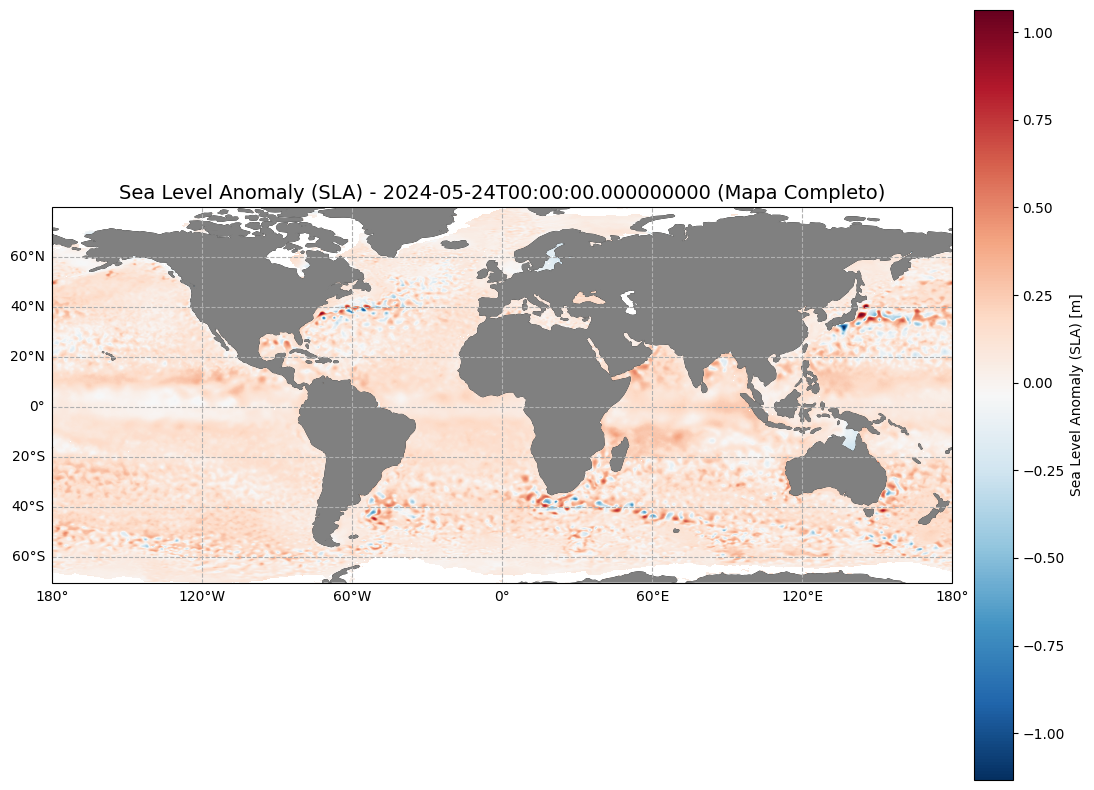

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

# Cargar los datos de altimetría
file_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240524_20240722.nc'
data = xr.open_dataset(file_path)
x = data['longitude'].values  # Ajustar la longitud restando 180
y = data['latitude'].values
sla = data['sla'].isel(time=0).values  # Seleccionar el primer día de SLA
X, Y = np.meshgrid(x, y)

# Configuración de la gráfica con Cartopy
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': projection})

# Graficar SLA completa
sla_plot = ax.pcolormesh(X, Y, sla, shading='nearest', cmap='RdBu_r', transform=projection)
cbar = plt.colorbar(sla_plot, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('Sea Level Anomaly (SLA) [m]')

# Agregar características del mapa y título
add_map_features(ax)
plt.title(f'Sea Level Anomaly (SLA) - {data.time[0].values} (Mapa Completo)', fontsize=14)
plt.show()


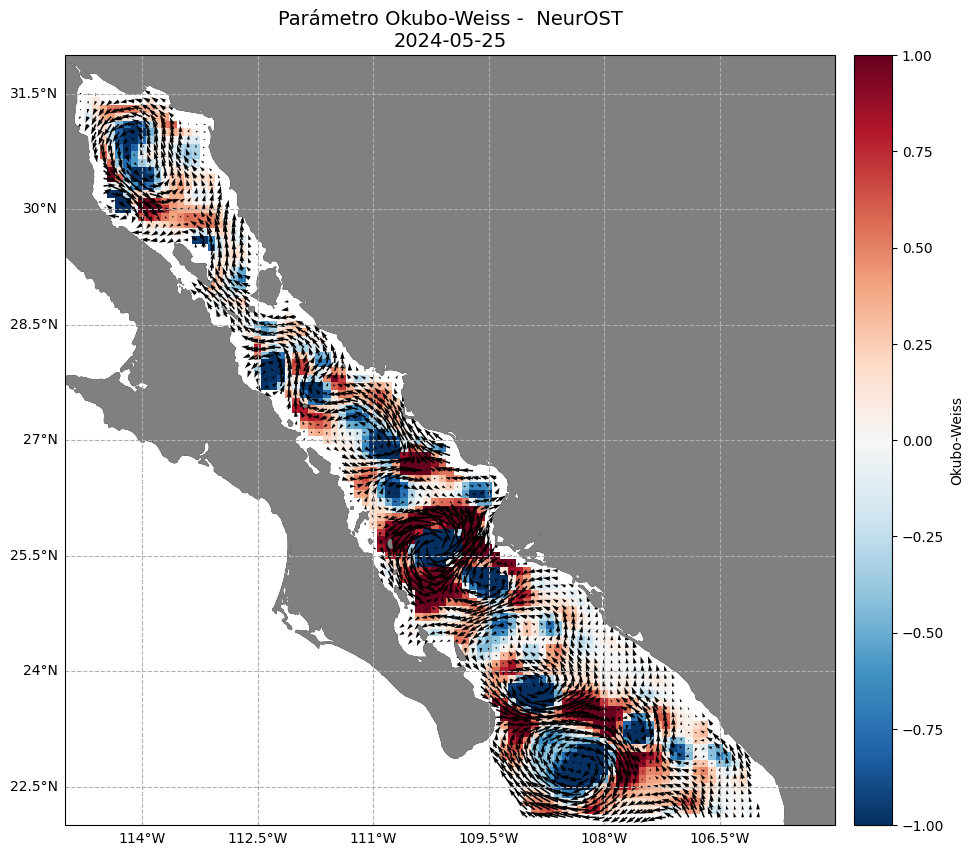

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    ax.set_extent([-115, -105, 22, 32], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

# Cargar los datos de altimetría
file_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240525_20240722.nc'
data = xr.open_dataset(file_path)
x = data['longitude'].values
y = data['latitude'].values
ugos = data['ugos'].isel(time=0).values  # Seleccionar el primer día
vgos = data['vgos'].isel(time=0).values
X, Y = np.meshgrid(x, y)
time = pd.to_datetime(data['time'].values[0])

# Cargar máscara del Golfo de California
# Suponiendo que tienes un archivo `GC_mask.mat` con las coordenadas xp e yp.
mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
xp = mask_data['xp'].flatten() + 360
yp = mask_data['yp'].flatten()
polygon_path = Path(np.column_stack((xp, yp)))
points = np.vstack((X.flatten(), Y.flatten())).T
mask = polygon_path.contains_points(points).reshape(X.shape)

# Aplicar la máscara a los componentes de velocidad
ugos_masked = np.where(mask, ugos, np.nan)
vgos_masked = np.where(mask, vgos, np.nan)

# Calcular derivadas y parámetro Okubo-Weiss
f = 1e-4  # Parámetro de Coriolis, ajusta este valor según el área de interés
dx = np.gradient(X, axis=1)
dy = np.gradient(Y, axis=0)
du_dx = np.gradient(ugos_masked, axis=1) / dx
du_dy = np.gradient(ugos_masked, axis=0) / dy
dv_dx = np.gradient(vgos_masked, axis=1) / dx
dv_dy = np.gradient(vgos_masked, axis=0) / dy
Sn = du_dx - dv_dy
Ss = du_dy + dv_dx
vorticity = dv_dx - du_dy
OW = (Sn**2 + Ss**2 - vorticity**2)  # Parámetro Okubo-Weiss sin normalizar por f^2

# Configuración de la gráfica con Cartopy
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': projection})

# Graficar Okubo-Weiss
ow_plot = ax.pcolormesh(X, Y, OW, shading='nearest', cmap='RdBu_r', vmin=-1, vmax=1, transform=projection)
cbar = plt.colorbar(ow_plot, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('Okubo-Weiss')

# Graficar vectores de corriente
q = ax.quiver(X, Y, ugos_masked, vgos_masked, transform=ccrs.PlateCarree(), scale=10, color='black', width=0.002)
ax.quiverkey(q, 0.9, 0.9, 0.2, '0.2 m/s', labelpos='E', coordinates='axes', fontproperties={'size': 10})

# Agregar características del mapa y título
add_map_features(ax)
plt.title(f'Parámetro Okubo-Weiss -  NeurOST\n{time.strftime("%Y-%m-%d")}', fontsize=14)
plt.show()


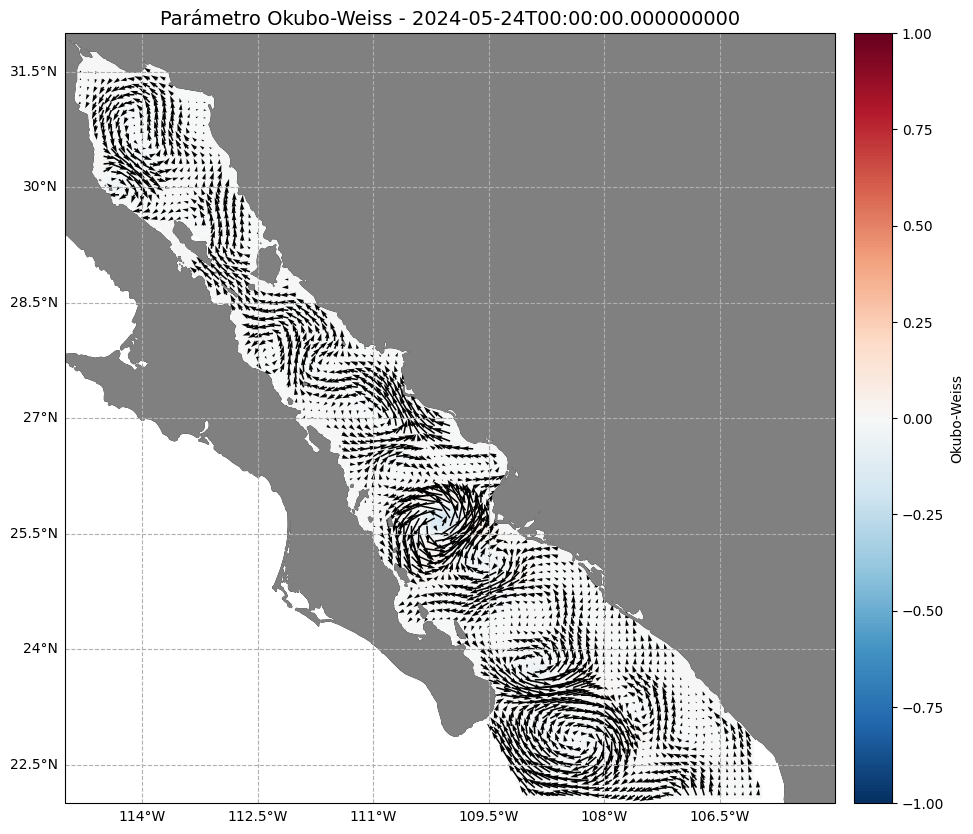

In [39]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    ax.set_extent([-115, -105, 22, 32], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

# Cargar los datos de altimetría y máscara
file_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240524_20240722.nc'
data = xr.open_dataset(file_path)
x = data['longitude'].values
y = data['latitude'].values
sla = data['sla'].isel(time=0).values  # Seleccionar el primer día de SLA
ugos = data['ugos'].isel(time=0).values
vgos = data['vgos'].isel(time=0).values
Sn = data['sn'].isel(time=0).values  # Utilizar cizalla normal del archivo
Ss = data['ss'].isel(time=0).values  # Utilizar cizalla de deformación del archivo
vorticity = data['zeta'].isel(time=0).values  # Utilizar vorticidad del archivo
X, Y = np.meshgrid(x, y)
time = pd.to_datetime(data['time'].values[0])

# Cargar máscara del Golfo de California y ajustar coordenadas
mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
xp = mask_data['xp'].flatten() + 360  # Ajustar las coordenadas sumando 360
yp = mask_data['yp'].flatten()
polygon_path = Path(np.column_stack((xp, yp)))
points = np.vstack((X.flatten(), Y.flatten())).T
mask = polygon_path.contains_points(points).reshape(X.shape)

# Aplicar la máscara y el detrend a SLA
masked_sla = np.where(mask, sla, np.nan)
finite_masked_sla = masked_sla[np.isfinite(masked_sla)]
detrended_finite_sla = detrend(finite_masked_sla, type='linear')
detrended_sla = np.full_like(sla, np.nan)
detrended_sla[np.isfinite(masked_sla)] = detrended_finite_sla

# Aplicar la máscara a los componentes de velocidad
ugos_masked = np.where(mask, ugos, np.nan)
vgos_masked = np.where(mask, vgos, np.nan)
Sn_masked = np.where(mask, Sn, np.nan)
Ss_masked = np.where(mask, Ss, np.nan)
vorticity_masked = np.where(mask, vorticity, np.nan)


# Calcular parámetro Okubo-Weiss utilizando las variables del archivo
OW = (Sn_masked**2 + Ss_masked**2 - vorticity_masked**2)/1e-4

# Configuración de la gráfica con Cartopy
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': projection})

# Graficar Okubo-Weiss
ow_plot = ax.pcolormesh(X, Y, OW, shading='nearest', cmap='RdBu_r', vmin=-.1, vmax=.1, transform=projection)
cbar = plt.colorbar(ow_plot, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('Okubo-Weiss')

# Graficar vectores de corriente
q = ax.quiver(X, Y, ugos_masked, vgos_masked, transform=ccrs.PlateCarree(), scale=10, color='black', width=0.002)
ax.quiverkey(q, 0.9, 0.9, 0.2, '0.2 m/s', labelpos='E', coordinates='axes', fontproperties={'size': 10})

# Agregar características del mapa y título
add_map_features(ax)
plt.title(f'Parámetro Okubo-Weiss - {data.time[0].values}', fontsize=14)
plt.show()


In [9]:
# Calcular parámetro Okubo-Weiss utilizando las variables del archivo
OW = (Sn_masked**2 + Ss_masked**2 - vorticity_masked**2)/1e-10

# Configuración de la gráfica con Cartopy
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': projection})

# Graficar Okubo-Weiss
ow_plot = ax.pcolormesh(X, Y, OW, shading='nearest', cmap='RdBu_r', vmin=-1, vmax=1, transform=projection)
cbar = plt.colorbar(ow_plot, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('Okubo-Weiss')

# Graficar vectores de corriente
q = ax.quiver(X, Y, ugos_masked, vgos_masked, transform=ccrs.PlateCarree(), scale=10, color='black', width=0.002)
ax.quiverkey(q, 0.9, 0.9, 0.2, '0.2 m/s', labelpos='E', coordinates='axes', fontproperties={'size': 10})

# Agregar características del mapa y título
add_map_features(ax)
plt.title(f'Parámetro Okubo-Weiss - NeurOST\n{time.strftime("%Y-%m-%d")}', fontsize=14)
plt.show()


NameError: name 'Sn_masked' is not defined

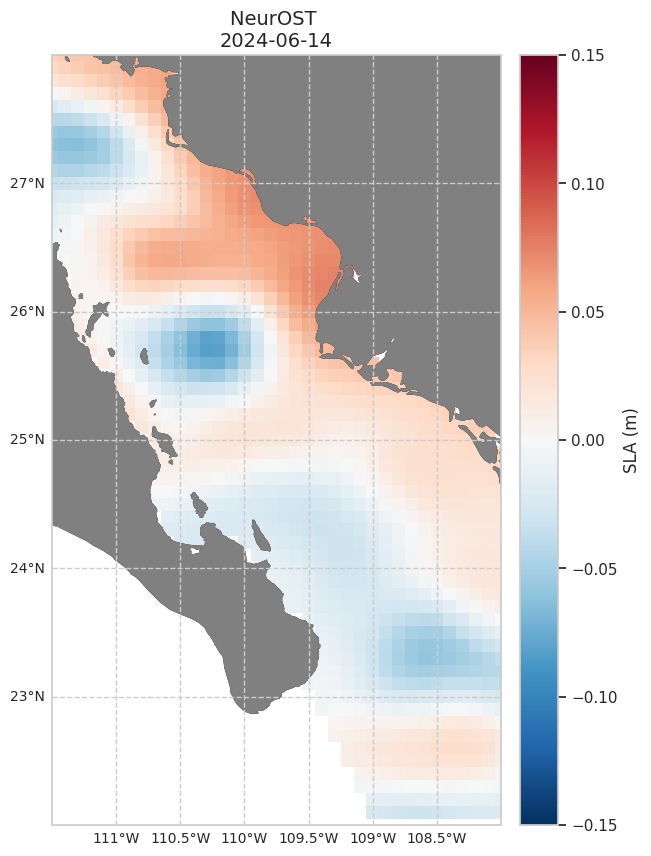

In [54]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from scipy.signal import detrend

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    ax.set_extent([-111.5, -108, 22, 28], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

# Cargar los datos de altimetría
file_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240614_20240722.nc'
data = xr.open_dataset(file_path)
x = data['longitude'].values
y = data['latitude'].values
sla = data['sla'].isel(time=0).values  # Seleccionar el primer día de SLA
X, Y = np.meshgrid(x, y)

# Cargar máscara del Golfo de California
mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
xp = mask_data['xp'].flatten() +360
yp = mask_data['yp'].flatten()
polygon_path = Path(np.column_stack((xp, yp)))
points = np.vstack((X.flatten(), Y.flatten())).T
mask = polygon_path.contains_points(points).reshape(X.shape)

# Aplicar la máscara a la variable SLA
masked_sla = np.where(mask, sla, np.nan)
finite_masked_sla = masked_sla[np.isfinite(masked_sla)]

# Aplicar detrend a los valores finitos dentro de la máscara
detrended_finite_sla = detrend(finite_masked_sla, type='linear')

# Reconstruir la matriz SLA detrendida con NaNs fuera de la máscara
detrended_sla = np.full_like(sla, np.nan)
detrended_sla[np.isfinite(masked_sla)] = detrended_finite_sla

# Configuración de la gráfica con Cartopy
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': projection})

# Graficar SLA detrendida dentro del área de la máscara
sla_plot = ax.pcolormesh(X, Y, detrended_sla, shading='nearest', cmap='RdBu_r', vmin=-0.15, vmax=0.15, transform=projection)
cbar = plt.colorbar(sla_plot, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('SLA (m)')

# Agregar características del mapa y título
add_map_features(ax)
plt.title(f'NeurOST \n2024-06-14', fontsize=14)#{data.time[0].values}', fontsize=14)
plt.show()


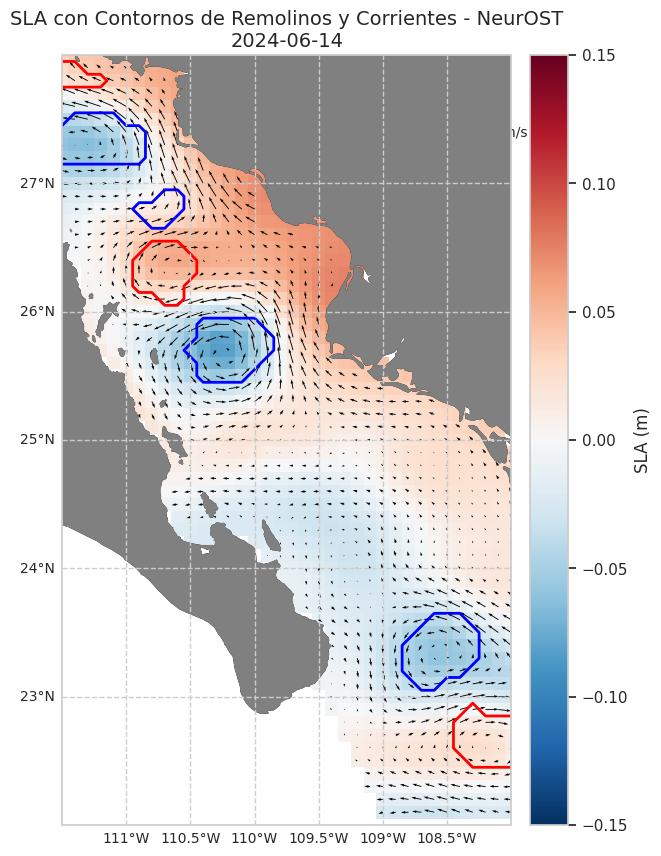

In [55]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from scipy.signal import detrend
from scipy.ndimage import label
from geopy.distance import geodesic
import pandas as pd

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    ax.set_extent([-111.5, -108, 22, 28], crs=ccrs.PlateCarree()) #sur del golfo
    #ax.set_extent([-115, -105, 22, 32], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

# Función para calcular el radio promedio de cada remolino
def calcular_radio(labeled, num_remolinos, X, Y):
    radios = []
    centros = []
    for i in range(1, num_remolinos + 1):
        coords = np.column_stack(np.where(labeled == i))
        longitudes = X[coords[:, 0], coords[:, 1]]
        latitudes = Y[coords[:, 0], coords[:, 1]]
        centro_longitud = np.mean(longitudes)
        centro_latitud = np.mean(latitudes)
        distancias = [geodesic((centro_latitud, centro_longitud), (lat, lon)).km for lon, lat in zip(longitudes, latitudes)]
        radio_medio = np.mean(distancias)
        radios.append(radio_medio)
        centros.append((centro_latitud, centro_longitud))
    return radios, centros

# Cargar los datos de altimetría y máscara
file_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240614_20240722.nc'
data = xr.open_dataset(file_path)
x = data['longitude'].values
y = data['latitude'].values
sla = data['sla'].isel(time=0).values  # Seleccionar el primer día de SLA
ugos = data['ugos'].isel(time=0).values
vgos = data['vgos'].isel(time=0).values
X, Y = np.meshgrid(x, y)
time = pd.to_datetime(data['time'].values[0])

# Cargar máscara del Golfo de California y ajustar coordenadas
mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
xp = mask_data['xp'].flatten() + 360  # Ajustar las coordenadas sumando 360
yp = mask_data['yp'].flatten()
polygon_path = Path(np.column_stack((xp, yp)))
points = np.vstack((X.flatten(), Y.flatten())).T
mask = polygon_path.contains_points(points).reshape(X.shape)

# Aplicar la máscara y el detrend a SLA
masked_sla = np.where(mask, sla, np.nan)
finite_masked_sla = masked_sla[np.isfinite(masked_sla)]
detrended_finite_sla = detrend(finite_masked_sla, type='linear')
detrended_sla = np.full_like(sla, np.nan)
detrended_sla[np.isfinite(masked_sla)] = detrended_finite_sla

# Aplicar la máscara a los componentes de velocidad
ugos_masked = np.where(mask, ugos, np.nan)
vgos_masked = np.where(mask, vgos, np.nan)

# Calcular derivadas y parámetro Okubo-Weiss
dx = np.gradient(X, axis=1)
dy = np.gradient(Y, axis=0)
du_dx = np.gradient(ugos, axis=1) / dx
du_dy = np.gradient(ugos, axis=0) / dy
dv_dx = np.gradient(vgos, axis=1) / dx
dv_dy = np.gradient(vgos, axis=0) / dy
Sn = du_dx - dv_dy
Ss = du_dy + dv_dx
vorticity = dv_dx - du_dy
OW = Sn**2 + Ss**2 - vorticity**2

# Identificar remolinos ciclónicos y anticiclónicos
remolinos_ciclonicos = np.logical_and(OW < -0.5, vorticity > 0)
remolinos_anticiclonicos = np.logical_and(OW <-0.5, vorticity < 0)

# Etiquetar remolinos y calcular radios
ciclonic_labeled, num_ciclonic = label(np.where(mask, remolinos_ciclonicos, 0))
anticiclonic_labeled, num_anticiclonic = label(np.where(mask, remolinos_anticiclonicos, 0))

radios_ciclonicos, centros_ciclonicos = calcular_radio(ciclonic_labeled, num_ciclonic, X, Y)
radios_anticiclonicos, centros_anticiclonicos = calcular_radio(anticiclonic_labeled, num_anticiclonic, X, Y)

# Filtrar remolinos con radio mayor a 10 km
ciclonic_valid = [i + 1 for i, r in enumerate(radios_ciclonicos) if r >= 10]
anticiclonic_valid = [i + 1 for i, r in enumerate(radios_anticiclonicos) if r >= 10]

# Fusión de remolinos cercanos (distancia menor a 0.25 km)
def fusionar_remolinos(centros, labeled_array, valid_labels):
    for i, centro1 in enumerate(centros):
        for j, centro2 in enumerate(centros):
            if i < j and geodesic(centro1, centro2).km < 0.25:
                labeled_array[labeled_array == valid_labels[j]] = valid_labels[i]
    return labeled_array

ciclonic_labeled = fusionar_remolinos(centros_ciclonicos, ciclonic_labeled, ciclonic_valid)
anticiclonic_labeled = fusionar_remolinos(centros_anticiclonicos, anticiclonic_labeled, anticiclonic_valid)

# Configuración de la gráfica con Cartopy
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': projection})

# Graficar SLA detrendida
sla_plot = ax.pcolormesh(X, Y, detrended_sla, shading='nearest', cmap='RdBu_r', vmin=-0.15, vmax=0.15, transform=projection)
cbar = plt.colorbar(sla_plot, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('SLA (m)')

# Contornos de remolinos con grosor ajustado
for label_value in ciclonic_valid:
    ax.contour(X, Y, ciclonic_labeled == label_value, colors='blue', linewidths=2, transform=projection)
for label_value in anticiclonic_valid:
    ax.contour(X, Y, anticiclonic_labeled == label_value, colors='red', linewidths=2, transform=projection)

# Graficar vectores de corriente más delgados y añadir escala de referencia
q = ax.quiver(X, Y, ugos_masked, vgos_masked, transform=ccrs.PlateCarree(), scale=10, color='black', width=0.002)
ax.quiverkey(q, 0.9, 0.9, 0.2, '0.2 m/s', labelpos='E', coordinates='axes', fontproperties={'size': 10})

# Agregar características del mapa y título
add_map_features(ax)
plt.title(f'SLA con Contornos de Remolinos y Corrientes - NeurOST\n{time.strftime("%Y-%m-%d")}', fontsize=14)
plt.show()


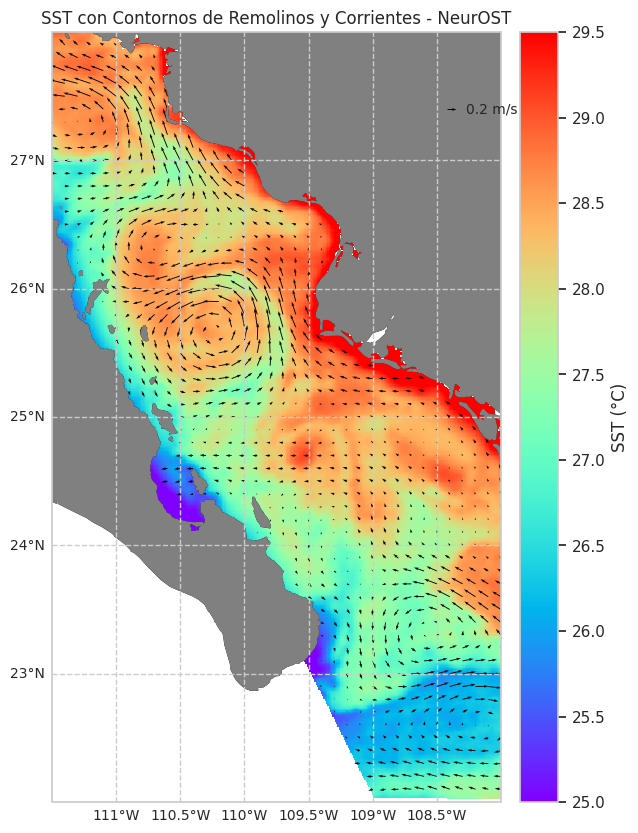

In [59]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from scipy.signal import detrend
from scipy.ndimage import label
from geopy.distance import geodesic
import pandas as pd

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    #ax.set_extent([-115, -111.5, 28.5, 32], crs=ccrs.PlateCarree()) #norte del golfo
    ax.set_extent([-111.5, -108, 22, 28], crs=ccrs.PlateCarree()) #sur del golfo
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

# Función para calcular el radio promedio de cada remolino
def calcular_radio(labeled, num_remolinos, X, Y):
    radios = []
    centros = []
    for i in range(1, num_remolinos + 1):
        coords = np.column_stack(np.where(labeled == i))
        if coords.size == 0:
            continue
        longitudes = X[coords[:, 0], coords[:, 1]]
        latitudes = Y[coords[:, 0], coords[:, 1]]
        centro_longitud = np.mean(longitudes)
        centro_latitud = np.mean(latitudes)
        distancias = [geodesic((centro_latitud, centro_longitud), (lat, lon)).km for lon, lat in zip(longitudes, latitudes)]
        if len(distancias) == 0:
            continue
        radio_medio = np.mean(distancias)
        radios.append(radio_medio)
        centros.append((centro_latitud, centro_longitud))
    return radios, centros

# Cargar los datos de SST y máscara
file_path = '/mnt/data/satelitales/SST/MUR-JPL-L4-GLOB-v4.1/GC-MUR-combined.nc'
data = xr.open_dataset(file_path)

# Filtrar los datos para el rango de fechas deseado
start_date = '2024-06-14'
end_date = '2024-06-15'
sst_data = data['analysed_sst'].sel(time=slice(start_date, end_date))

# Cargar la máscara del Golfo de California y ajustar coordenadas
mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación del archivo
xp = mask_data['xp'].flatten()  # Ajustar las coordenadas sumando 360
yp = mask_data['yp'].flatten()
polygon_path = Path(np.column_stack((xp, yp)))
polygon_path2 = Path(np.column_stack((xp +360, yp)))

# Crear la malla de puntos de longitud y latitud para la SST
initial_data = sst_data.isel(time=0)
lon_sst, lat_sst = np.meshgrid(initial_data['lon'].values, initial_data['lat'].values)
points_sst = np.vstack((lon_sst.flatten(), lat_sst.flatten())).T

# Verificar si los puntos están dentro del polígono para la SST
mask_sst = polygon_path.contains_points(points_sst).reshape(lon_sst.shape)

# Aplicar la máscara a los datos SST
masked_sst_data = np.where(mask_sst, initial_data.values - 273, np.nan)  # Convertir a Celsius si está dentro de la máscara

# Cargar los datos de altimetría y componentes de velocidad
ssh_file_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240614_20240722.nc'
ssh_data = xr.open_dataset(ssh_file_path)
sla = ssh_data['sla'].isel(time=0).values  # Seleccionar el primer día de SLA
ugos = ssh_data['ugos'].isel(time=0).values
vgos = ssh_data['vgos'].isel(time=0).values
X, Y = np.meshgrid(ssh_data['longitude'].values, ssh_data['latitude'].values)

# Redimensionar la máscara para ajustarla a la resolución de SLA y componentes de velocidad
lon_ssh, lat_ssh = np.meshgrid(ssh_data['longitude'].values, ssh_data['latitude'].values)
points_ssh = np.vstack((lon_ssh.flatten(), lat_ssh.flatten())).T
mask_ssh = polygon_path2.contains_points(points_ssh).reshape(lon_ssh.shape)

# Aplicar la máscara a SLA y los componentes de velocidad
masked_sla = np.where(mask_ssh, sla, np.nan)
ugos_masked = np.where(mask_ssh, ugos, np.nan)
vgos_masked = np.where(mask_ssh, vgos, np.nan)

# Calcular derivadas y parámetro Okubo-Weiss
dx = np.gradient(X, axis=1)
dy = np.gradient(Y, axis=0)
du_dx = np.gradient(ugos, axis=1) / dx
du_dy = np.gradient(ugos, axis=0) / dy
dv_dx = np.gradient(vgos, axis=1) / dx
dv_dy = np.gradient(vgos, axis=0) / dy
Sn = du_dx - dv_dy
Ss = du_dy + dv_dx
vorticity = dv_dx - du_dy
OW = Sn**2 + Ss**2 - vorticity**2

# Identificar remolinos ciclónicos y anticiclónicos
remolinos_ciclonicos = np.logical_and(OW < -0.5, vorticity > 0)
remolinos_anticiclonicos = np.logical_and(OW < -0.5, vorticity < 0)

# Etiquetar remolinos y calcular radios
ciclonic_labeled, num_ciclonic = label(np.where(mask_ssh, remolinos_ciclonicos, 0))
anticiclonic_labeled, num_anticiclonico = label(np.where(mask_ssh, remolinos_anticiclonicos, 0))

radios_ciclonicos, centros_ciclonicos = calcular_radio(ciclonic_labeled, num_ciclonic, X, Y)
radios_anticiclonicos, centros_anticiclonicos = calcular_radio(anticiclonic_labeled, num_anticiclonico, X, Y)

# Filtrar remolinos con radio mayor a 10 km
ciclonic_valid = [i + 1 for i, r in enumerate(radios_ciclonicos) if r >= 10]
anticiclonic_valid = [i + 1 for i, r in enumerate(radios_anticiclonicos) if r >= 10]

# Fusión de remolinos cercanos (distancia menor a 0.25 km)
def fusionar_remolinos(centros, labeled_array, valid_labels):
    for i, centro1 in enumerate(centros):
        for j, centro2 in enumerate(centros):
            if i < j and not np.isnan(centro1[0]) and not np.isnan(centro2[0]):
                if geodesic(centro1, centro2).km < 0.25:
                    labeled_array[labeled_array == valid_labels[j]] = valid_labels[i]
    return labeled_array

ciclonic_labeled = fusionar_remolinos(centros_ciclonicos, ciclonic_labeled, ciclonic_valid)
anticiclonic_labeled = fusionar_remolinos(centros_anticiclonicos, anticiclonic_labeled, anticiclonic_valid)

# Crear la figura y el mapa con Cartopy
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Graficar SST
img = ax.pcolormesh(initial_data['lon'], initial_data['lat'], masked_sst_data, cmap='rainbow', shading='auto', transform=ccrs.PlateCarree(), vmin=25, vmax=29.5)
cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('SST (°C)')

# Contornos de remolinos con grosor ajustado
#for label_value in ciclonic_valid:
   # ax.contour(X, Y, ciclonic_labeled == label_value, colors='blue', linewidths=2, transform=ccrs.PlateCarree())
#for label_value in anticiclonic_valid:
   # ax.contour(X, Y, anticiclonic_labeled == label_value, colors='red', linewidths=2, transform=ccrs.PlateCarree())

# Graficar vectores de corriente más delgados y añadir escala de referencia
q = ax.quiver(X, Y, ugos_masked, vgos_masked, transform=ccrs.PlateCarree(), scale=10, color='black', width=0.002)


# Agregar características del mapa y título
add_map_features(ax)
qk = ax.quiverkey(q, 0.9, 0.9, 0.2, '0.2 m/s', labelpos='E', coordinates='axes', fontproperties={'size': 10})
qk.set_zorder(10)  # Ajusta el valor para que la quiverkey esté al frente

plt.title("SST con Contornos de Remolinos y Corrientes - NeurOST")
plt.show()

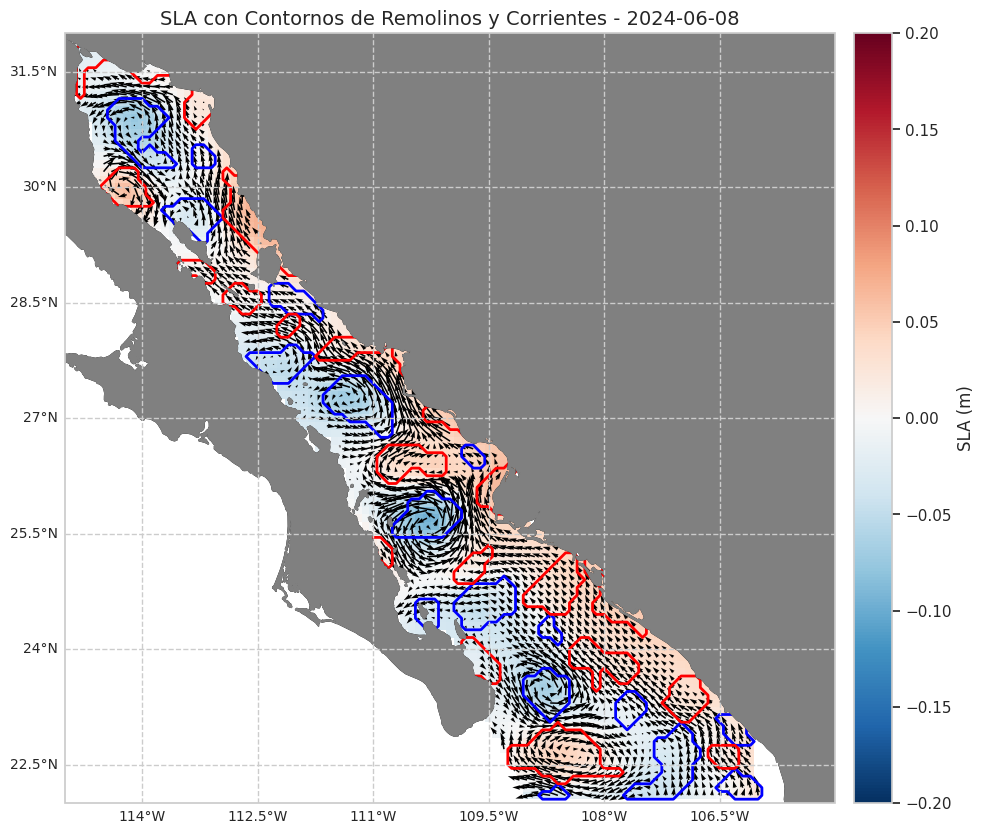

In [38]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from scipy.signal import detrend
from scipy.ndimage import label
from geopy.distance import geodesic
import pandas as pd

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    ax.set_extent([-115, -105, 22, 32], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

# Función para calcular el radio promedio de cada remolino
def calcular_radio(labeled, num_remolinos, X, Y):
    radios = []
    centros = []
    for i in range(1, num_remolinos + 1):
        coords = np.column_stack(np.where(labeled == i))
        longitudes = X[coords[:, 0], coords[:, 1]]
        latitudes = Y[coords[:, 0], coords[:, 1]]
        centro_longitud = np.mean(longitudes)
        centro_latitud = np.mean(latitudes)
        distancias = [geodesic((centro_latitud, centro_longitud), (lat, lon)).km for lon, lat in zip(longitudes, latitudes)]
        radio_medio = np.mean(distancias)
        radios.append(radio_medio)
        centros.append((centro_latitud, centro_longitud))
    return radios, centros

# Cargar los datos de altimetría y máscara
file_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240608_20240722.nc'
data = xr.open_dataset(file_path)
x = data['longitude'].values
y = data['latitude'].values
sla = data['sla'].isel(time=0).values  # Seleccionar el primer día de SLA
ugos = data['ugos'].isel(time=0).values
vgos = data['vgos'].isel(time=0).values
Sn = data['sn'].isel(time=0).values  # Utilizar cizalla normal del archivo
Ss = data['ss'].isel(time=0).values  # Utilizar cizalla de deformación del archivo
vorticity = data['zeta'].isel(time=0).values  # Utilizar vorticidad del archivo
X, Y = np.meshgrid(x, y)
time = pd.to_datetime(data['time'].values[0])

# Cargar máscara del Golfo de California y ajustar coordenadas
mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
xp = mask_data['xp'].flatten() + 360  # Ajustar las coordenadas sumando 360
yp = mask_data['yp'].flatten()
polygon_path = Path(np.column_stack((xp, yp)))
points = np.vstack((X.flatten(), Y.flatten())).T
mask = polygon_path.contains_points(points).reshape(X.shape)

# Aplicar la máscara y el detrend a SLA
masked_sla = np.where(mask, sla, np.nan)
finite_masked_sla = masked_sla[np.isfinite(masked_sla)]
detrended_finite_sla = detrend(finite_masked_sla, type='linear')
detrended_sla = np.full_like(sla, np.nan)
detrended_sla[np.isfinite(masked_sla)] = detrended_finite_sla

# Aplicar la máscara a los componentes de velocidad
ugos_masked = np.where(mask, ugos, np.nan)
vgos_masked = np.where(mask, vgos, np.nan)

# Calcular parámetro Okubo-Weiss utilizando las variables del archivo
OW = Sn**2 + Ss**2 - vorticity**2

# Identificar remolinos ciclónicos y anticiclónicos
remolinos_ciclonicos = np.logical_and(OW < -0, vorticity > 0)
remolinos_anticiclonicos = np.logical_and(OW < -0, vorticity < 0)

# Etiquetar remolinos y calcular radios
ciclonic_labeled, num_ciclonic = label(np.where(mask, remolinos_ciclonicos, 0))
anticiclonic_labeled, num_anticiclonic = label(np.where(mask, remolinos_anticiclonicos, 0))

radios_ciclonicos, centros_ciclonicos = calcular_radio(ciclonic_labeled, num_ciclonic, X, Y)
radios_anticiclonicos, centros_anticiclonicos = calcular_radio(anticiclonic_labeled, num_anticiclonic, X, Y)

# Filtrar remolinos con radio mayor a 10 km
ciclonic_valid = [i + 1 for i, r in enumerate(radios_ciclonicos) if r >= 10]
anticiclonic_valid = [i + 1 for i, r in enumerate(radios_anticiclonicos) if r >= 10]

# Fusión de remolinos cercanos (distancia menor a 0.25 km)
def fusionar_remolinos(centros, labeled_array, valid_labels):
    for i, centro1 in enumerate(centros):
        for j, centro2 in enumerate(centros):
            if i < j and geodesic(centro1, centro2).km < 0.25:
                labeled_array[labeled_array == valid_labels[j]] = valid_labels[i]
    return labeled_array

ciclonic_labeled = fusionar_remolinos(centros_ciclonicos, ciclonic_labeled, ciclonic_valid)
anticiclonic_labeled = fusionar_remolinos(centros_anticiclonicos, anticiclonic_labeled, anticiclonic_valid)

# Configuración de la gráfica con Cartopy
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': projection})

# Graficar SLA detrendida
sla_plot = ax.pcolormesh(X, Y, detrended_sla, shading='nearest', cmap='RdBu_r', vmin=-0.2, vmax=0.2, transform=projection)
cbar = plt.colorbar(sla_plot, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('SLA (m)')

# Contornos de remolinos con grosor ajustado
for label_value in ciclonic_valid:
    ax.contour(X, Y, ciclonic_labeled == label_value, colors='blue', linewidths=2, transform=projection)
for label_value in anticiclonic_valid:
    ax.contour(X, Y, anticiclonic_labeled == label_value, colors='red', linewidths=2, transform=projection)

# Graficar vectores de corriente más delgados y añadir escala de referencia
q = ax.quiver(X, Y, ugos_masked, vgos_masked, transform=ccrs.PlateCarree(), scale=10, color='black', width=0.002)
ax.quiverkey(q, 0.9, 0.9, 0.2, '0.2 m/s', labelpos='E', coordinates='axes', fontproperties={'size': 10})

# Agregar características del mapa y título
add_map_features(ax)
plt.title(f'SLA con Contornos de Remolinos y Corrientes - {time.strftime("%Y-%m-%d")}', fontsize=14)
plt.show()


In [1]:
# Recorte de archivos NeurOST

import os
import xarray as xr

# Directorio de entrada y salida
input_dir = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024'
output_dir = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC'

# Crear el directorio de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Definir límites del Golfo de California
lat_min, lat_max = 22, 33
lon_min, lon_max = -116, -106

# Procesar cada archivo en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".nc"):
        input_file_path = os.path.join(input_dir, filename)
        output_file_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_GC.nc")

        # Cargar el archivo NetCDF
        data = xr.open_dataset(input_file_path)

        # Convertir longitudes al formato 0-360 si es necesario
        if data.longitude.max() > 180:
            lon_min_gc = lon_min + 360
            lon_max_gc = lon_max + 360
        else:
            lon_min_gc = lon_min
            lon_max_gc = lon_max

        # Recortar el archivo al área del Golfo de California
        data_gc = data.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min_gc, lon_max_gc))

        # Guardar el archivo recortado
        data_gc.to_netcdf(output_file_path)

        print(f"Archivo recortado guardado en {output_file_path}")

print("Proceso de recorte completado.")


Archivo recortado guardado en /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC/NeurOST_SSH-SST_20240614_20240722_GC.nc
Archivo recortado guardado en /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC/NeurOST_SSH-SST_20240613_20240722_GC.nc
Archivo recortado guardado en /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC/NeurOST_SSH-SST_20240612_20240722_GC.nc
Archivo recortado guardado en /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC/NeurOST_SSH-SST_20240611_20240722_GC.nc
Archivo recortado guardado en /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC/NeurOST_SSH-SST_20240610_20240722_GC.nc
Archivo recortado guardado en /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC/NeurOST_SSH-SST_20240609_20240722_GC.nc
Archivo recortado guardado en /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC/NeurOST_SSH-SST_20240608_20240722_GC.nc
Archivo recortado guardado en /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC/NeurOST_SSH-SST_20240607_20240722_GC.nc
Archivo 

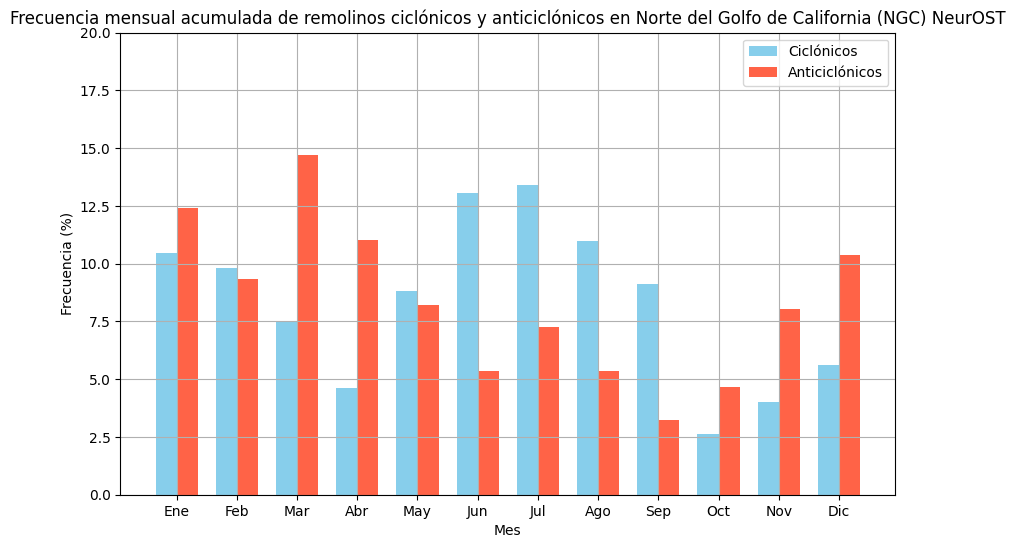

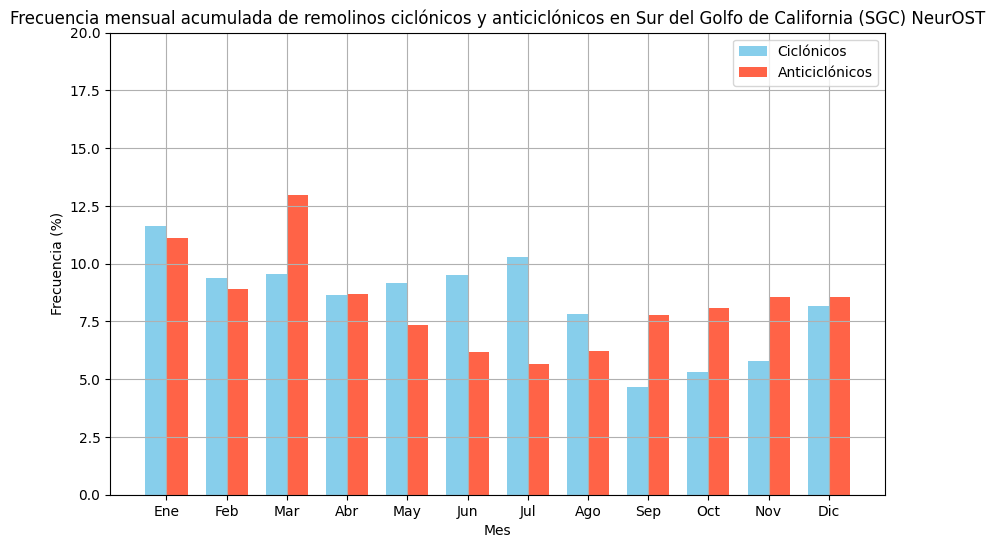

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.io import loadmat
from scipy.ndimage import label
from geopy.distance import geodesic
import pandas as pd
import os

# Definir límites de las regiones del Golfo de California
NGC_bounds = (28.5, 32)  # Latitud norte de 28° a 32°
CGC_SGC_bounds = (22, 28.5)  # Latitud combinada centro-sur de 22° a 28°

# Función para calcular el radio promedio de cada remolino
def calcular_radio(labeled, num_remolinos, X, Y):
    radios = []
    centros = []
    for i in range(1, num_remolinos + 1):
        coords = np.column_stack(np.where(labeled == i))
        longitudes = X[coords[:, 0], coords[:, 1]]
        latitudes = Y[coords[:, 0], coords[:, 1]]
        centro_longitud = np.mean(longitudes)
        centro_latitud = np.mean(latitudes)
        distancias = [geodesic((centro_latitud, centro_longitud), (lat, lon)).km for lon, lat in zip(longitudes, latitudes)]
        radio_medio = np.mean(distancias)
        radios.append(radio_medio)
        centros.append((centro_latitud, centro_longitud))
    return radios, centros

# Directorio de los archivos recortados del Golfo de California
input_dir = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC'

# Inicializar contadores acumulados
count_ciclonic_ngc_total = np.zeros(12)
count_anticiclonic_ngc_total = np.zeros(12)
count_ciclonic_sgc_total = np.zeros(12)
count_anticiclonic_sgc_total = np.zeros(12)

# Procesar cada archivo en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".nc"):
        file_path = os.path.join(input_dir, filename)
        data = xr.open_dataset(file_path)
        
        x = data['longitude'].values
        y = data['latitude'].values
        sla = data['sla'].isel(time=0).values  # Seleccionar el primer día de SLA
        ugos = data['ugos'].isel(time=0).values
        vgos = data['vgos'].isel(time=0).values
        X, Y = np.meshgrid(x, y)
        time = pd.to_datetime(filename.split('_')[2])  # Obtener la fecha del nombre del archivo

        # Cargar máscara del Golfo de California y ajustar coordenadas
        mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
        xp = mask_data['xp'].flatten() + 360  # Ajustar las coordenadas sumando 360
        yp = mask_data['yp'].flatten()
        polygon_path = Path(np.column_stack((xp, yp)))
        points = np.vstack((X.flatten(), Y.flatten())).T
        mask = polygon_path.contains_points(points).reshape(X.shape)

        # Aplicar la máscara a SLA y las corrientes
        masked_sla = np.where(mask, sla, np.nan)
        ugos_masked = np.where(mask, ugos, np.nan)
        vgos_masked = np.where(mask, vgos, np.nan)

        # Calcular derivadas espaciales para el parámetro Okubo-Weiss
        dx = np.gradient(X, axis=1)
        dy = np.gradient(Y, axis=0)
        du_dx = np.gradient(ugos_masked, axis=1) / dx
        du_dy = np.gradient(ugos_masked, axis=0) / dy
        dv_dx = np.gradient(vgos_masked, axis=1) / dx
        dv_dy = np.gradient(vgos_masked, axis=0) / dy
        Sn = du_dx - dv_dy
        Ss = du_dy + dv_dx
        vorticity = dv_dx - du_dy
        OW = Sn**2 + Ss**2 - vorticity**2

        # Identificar remolinos ciclónicos y anticiclónicos con OW < -0.5
        remolinos_ciclonicos = np.logical_and(OW < -0.5, vorticity > 0)
        remolinos_anticiclonicos = np.logical_and(OW < -0.5, vorticity < 0)
        ciclonic_labeled, num_ciclonic = label(remolinos_ciclonicos)
        anticiclonic_labeled, num_anticiclonico = label(remolinos_anticiclonicos)

        # Función para contar remolinos por mes en una región
        def contar_remolinos_por_mes(ciclonic_labeled, anticiclonic_labeled, time_data, bounds):
            count_ciclonic = np.zeros(12)
            count_anticiclonic = np.zeros(12)
            
            month = time_data.month
            count_ciclonic[month - 1] += np.sum((ciclonic_labeled > 0) & ((bounds[0] <= Y) & (Y < bounds[1])))
            count_anticiclonic[month - 1] += np.sum((anticiclonic_labeled > 0) & ((bounds[0] <= Y) & (Y < bounds[1])))

            return count_ciclonic, count_anticiclonic

        # Contar remolinos por mes en cada región y acumular
        count_ciclonic_ngc, count_anticiclonic_ngc = contar_remolinos_por_mes(ciclonic_labeled, anticiclonic_labeled, time, NGC_bounds)
        count_ciclonic_sgc, count_anticiclonic_sgc = contar_remolinos_por_mes(ciclonic_labeled, anticiclonic_labeled, time, CGC_SGC_bounds)

        count_ciclonic_ngc_total += count_ciclonic_ngc
        count_anticiclonic_ngc_total += count_anticiclonic_ngc
        count_ciclonic_sgc_total += count_ciclonic_sgc
        count_anticiclonic_sgc_total += count_anticiclonic_sgc

# Graficar frecuencia mensual de remolinos acumulada

def graficar_frecuencia_mensual(count_ciclonic, count_anticiclonic, region_name):
    total_ciclonic = np.sum(count_ciclonic)
    total_anticiclonic = np.sum(count_anticiclonic)
    frecuencia_ciclonic = (count_ciclonic / total_ciclonic) * 100 if total_ciclonic > 0 else np.zeros(12)
    frecuencia_anticiclonic = (count_anticiclonic / total_anticiclonic) * 100 if total_anticiclonic > 0 else np.zeros(12)

    bar_width = 0.35
    index = np.arange(12)
    meses_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

    plt.figure(figsize=(10, 6))
    plt.bar(index, frecuencia_ciclonic, bar_width, label='Ciclónicos', color='skyblue')
    plt.bar(index + bar_width, frecuencia_anticiclonic, bar_width, label='Anticiclónicos', color='tomato')
    
    plt.xlabel('Mes')
    plt.ylabel('Frecuencia (%)')
    plt.title(f'Frecuencia mensual acumulada de remolinos ciclónicos y anticiclónicos en {region_name} NeurOST')
    plt.xticks(index + bar_width / 2, meses_labels)
    plt.ylim(0, 20)
    plt.legend()
    plt.grid(True)
    plt.show()

# Graficar frecuencia mensual acumulada por región
graficar_frecuencia_mensual(count_ciclonic_ngc_total, count_anticiclonic_ngc_total, 'Norte del Golfo de California (NGC)')
graficar_frecuencia_mensual(count_ciclonic_sgc_total, count_anticiclonic_sgc_total, 'Sur del Golfo de California (SGC)')


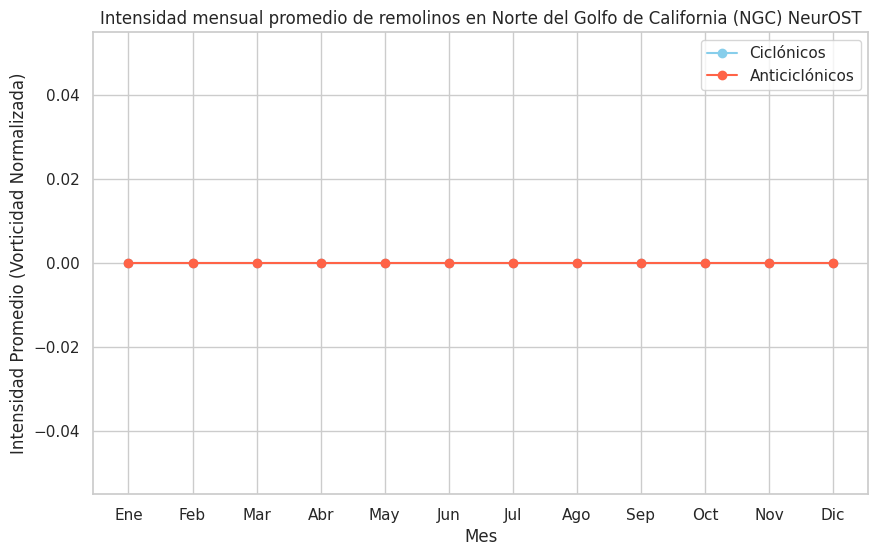

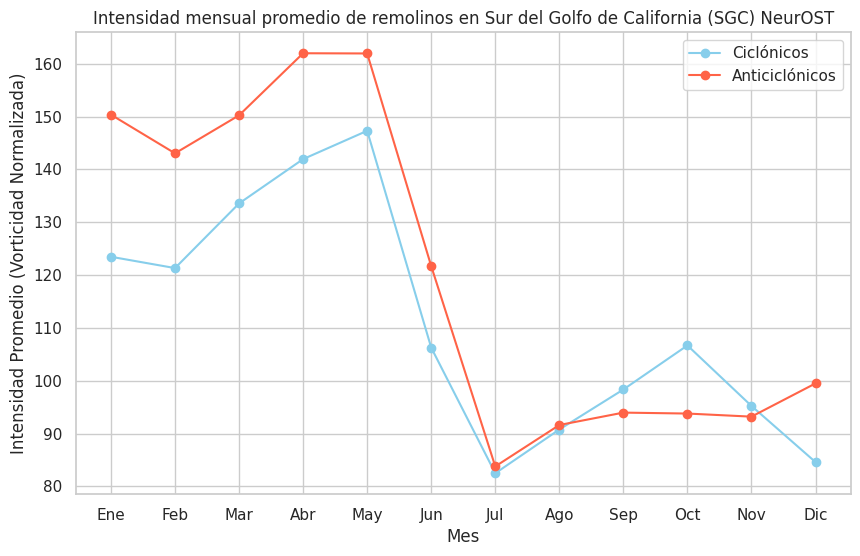

In [37]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.io import loadmat
from scipy.ndimage import label
from geopy.distance import geodesic
import pandas as pd
import os

# Definir límites de las regiones del Golfo de California
NGC_bounds = (28.5, 32)  # Latitud norte de 28° a 32°
CGC_SGC_bounds = (22, 28.5)  # Latitud combinada centro-sur de 22° a 28°

# Directorio de los archivos recortados del Golfo de California
input_dir = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC'

# Inicializar listas para almacenar la intensidad acumulada
intensidad_ciclonicos_ngc = np.zeros(12)
intensidad_anticiclonicos_ngc = np.zeros(12)
intensidad_ciclonicos_sgc = np.zeros(12)
intensidad_anticiclonicos_sgc = np.zeros(12)

# Función para calcular la intensidad promedio de cada remolino (basado en la vorticidad normalizada)
def calcular_intensidad_vorticidad_normalizada(labeled, num_remolinos, vorticity_normalizada):
    intensidades = []
    for i in range(1, num_remolinos + 1):
        mask_remolino = (labeled == i)
        intensidad_promedio = np.nanmean(np.abs(vorticity_normalizada[mask_remolino]))  # Vorticidad absoluta para normalizar
        intensidades.append(intensidad_promedio)
    return intensidades

# Procesar cada archivo en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".nc"):
        file_path = os.path.join(input_dir, filename)
        data = xr.open_dataset(file_path)
        
        x = data['longitude'].values
        y = data['latitude'].values
        sla = data['sla'].isel(time=0).values  # Seleccionar el primer día de SLA
        ugos = data['ugos'].isel(time=0).values
        vgos = data['vgos'].isel(time=0).values
        X, Y = np.meshgrid(x, y)
        time = pd.to_datetime(filename.split('_')[2])  # Obtener la fecha del nombre del archivo
        month = time.month - 1  # Para indexar de 0 a 11

        # Cargar máscara del Golfo de California y ajustar coordenadas
        mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
        xp = mask_data['xp'].flatten() + 360  # Ajustar las coordenadas sumando 360
        yp = mask_data['yp'].flatten()
        polygon_path = Path(np.column_stack((xp, yp)))
        points = np.vstack((X.flatten(), Y.flatten())).T
        mask = polygon_path.contains_points(points).reshape(X.shape)

        # Aplicar la máscara a SLA y las corrientes
        masked_sla = np.where(mask, sla, np.nan)
        ugos_masked = np.where(mask, ugos, np.nan)
        vgos_masked = np.where(mask, vgos, np.nan)

        # Calcular derivadas espaciales para el parámetro Okubo-Weiss
        dx = np.gradient(X, axis=1)
        dy = np.gradient(Y, axis=0)
        du_dx = np.gradient(ugos_masked, axis=1) / dx
        du_dy = np.gradient(ugos_masked, axis=0) / dy
        dv_dx = np.gradient(vgos_masked, axis=1) / dx
        dv_dy = np.gradient(vgos_masked, axis=0) / dy
        Sn = du_dx - dv_dy  # Cizalla normal
        Ss = du_dy + dv_dx  # Cizalla de cizalladura
        vorticity = dv_dx - du_dy  # Vorticidad
        OW = Sn**2 + Ss**2 - vorticity**2  # Cálculo del parámetro Okubo-Weiss

        # Normalizar la vorticidad
        vorticity_mean = np.nanmean(vorticity)
        vorticity_std = np.nanstd(vorticity)
        vorticity_normalizada = (vorticity - vorticity_mean) / vorticity_std

        # Identificar remolinos ciclónicos y anticiclónicos con OW < -0.5
        remolinos_ciclonicos = np.logical_and(OW < -0.5, vorticity_normalizada > 0)
        remolinos_anticiclonicos = np.logical_and(OW < -0.5, vorticity_normalizada < 0)
        ciclonic_labeled, num_ciclonic = label(remolinos_ciclonicos)
        anticiclonic_labeled, num_anticiclonico = label(remolinos_anticiclonicos)

        # Calcular la intensidad de los remolinos ciclónicos y anticiclónicos
        intensidad_ciclonicos = calcular_intensidad_vorticidad_normalizada(ciclonic_labeled, num_ciclonic, vorticity_normalizada)
        intensidad_anticiclonicos = calcular_intensidad_vorticidad_normalizada(anticiclonic_labeled, num_anticiclonico, vorticity_normalizada)

        # Función para acumular intensidad por región
        def acumular_intensidad_por_region(centros, intensidades, bounds):
            return [intensidad for intensidad, (lat, lon) in zip(intensidades, centros) if bounds[0] <= lat < bounds[1]]

        # Acumular intensidad por región y mes
        centros_ciclonicos = np.column_stack(np.where(ciclonic_labeled > 0))
        centros_ciclonicos = [(Y[coord[0], coord[1]], X[coord[0], coord[1]]) for coord in centros_ciclonicos]
        centros_anticiclonicos = np.column_stack(np.where(anticiclonic_labeled > 0))
        centros_anticiclonicos = [(Y[coord[0], coord[1]], X[coord[0], coord[1]]) for coord in centros_anticiclonicos]

        intensidad_ciclonicos_ngc_mes = acumular_intensidad_por_region(centros_ciclonicos, intensidad_ciclonicos, NGC_bounds)
        intensidad_anticiclonicos_ngc_mes = acumular_intensidad_por_region(centros_anticiclonicos, intensidad_anticiclonicos, NGC_bounds)
        intensidad_ciclonicos_sgc_mes = acumular_intensidad_por_region(centros_ciclonicos, intensidad_ciclonicos, CGC_SGC_bounds)
        intensidad_anticiclonicos_sgc_mes = acumular_intensidad_por_region(centros_anticiclonicos, intensidad_anticiclonicos, CGC_SGC_bounds)

        if len(intensidad_ciclonicos_ngc_mes) > 0:
            intensidad_ciclonicos_ngc[month] += np.nanmean(intensidad_ciclonicos_ngc_mes)
        if len(intensidad_anticiclonicos_ngc_mes) > 0:
            intensidad_anticiclonicos_ngc[month] += np.nanmean(intensidad_anticiclonicos_ngc_mes)
        if len(intensidad_ciclonicos_sgc_mes) > 0:
            intensidad_ciclonicos_sgc[month] += np.nanmean(intensidad_ciclonicos_sgc_mes)
        if len(intensidad_anticiclonicos_sgc_mes) > 0:
            intensidad_anticiclonicos_sgc[month] += np.nanmean(intensidad_anticiclonicos_sgc_mes)

# Graficar intensidad mensual promedio de remolinos acumulada

def graficar_intensidad_mensual(intensidad_ciclonicos, intensidad_anticiclonicos, region_name):
    meses_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

    plt.figure(figsize=(10, 6))
    plt.plot(meses_labels, intensidad_ciclonicos, label='Ciclónicos', color='skyblue', marker='o')
    plt.plot(meses_labels, intensidad_anticiclonicos, label='Anticiclónicos', color='tomato', marker='o')
    
    plt.xlabel('Mes')
    plt.ylabel('Intensidad Promedio (Vorticidad Normalizada)')
    plt.title(f'Intensidad mensual promedio de remolinos en {region_name} NeurOST')
    plt.legend()
    plt.grid(True)
    plt.show()

# Graficar intensidad mensual acumulada por región
graficar_intensidad_mensual(intensidad_ciclonicos_ngc, intensidad_anticiclonicos_ngc, 'Norte del Golfo de California (NGC)')
graficar_intensidad_mensual(intensidad_ciclonicos_sgc, intensidad_anticiclonicos_sgc, 'Sur del Golfo de California (SGC)')

In [30]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.path import Path
from scipy.io import loadmat
from scipy.ndimage import label
from geopy.distance import geodesic
import pandas as pd
import os

# Configuración de seaborn
sns.set(style="whitegrid")

# Definir los límites de las regiones del Golfo de California
NGC_bounds = (28.5, 32)  # Norte del Golfo de California
CGC_SGC_bounds = (22, 28.5)  # Centro y Sur del Golfo de California combinados

# Directorio de los archivos recortados del Golfo de California
input_dir = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC'

# Inicializar listas para almacenar radios y tiempos de vida
radios_ciclonicos_total = []
tiempo_vida_ciclonicos_total = []
radios_anticiclonicos_total = []
tiempo_vida_anticiclonicos_total = []
centros_ciclonicos_total = []
centros_anticiclonicos_total = []

# Funciones de ayuda

# Función para calcular radios de remolinos
def calcular_radio(labeled, num_remolinos, X, Y):
    radios = []
    centros = []
    for i in range(1, num_remolinos + 1):
        coords = np.column_stack(np.where(labeled == i))
        coords[:, 0] = np.clip(coords[:, 0], 0, X.shape[0] - 1)
        coords[:, 1] = np.clip(coords[:, 1], 0, X.shape[1] - 1)

        longitudes = X[coords[:, 0], coords[:, 1]]
        latitudes = Y[coords[:, 0], coords[:, 1]]
        centro_longitud = np.mean(longitudes)
        centro_latitud = np.mean(latitudes)

        distancias = [geodesic((centro_latitud, centro_longitud), (lat, lon)).km for lon, lat in zip(longitudes, latitudes)]
        radio_medio = np.mean(distancias)

        if radio_medio >= 10:  # Filtrar remolinos con radio mayor a 10 km
            radios.append(radio_medio)
            centros.append((centro_latitud, centro_longitud))
    return radios, centros

# Función para calcular el tiempo de vida de los remolinos
def calcular_tiempo_vida(labeled, time_data):
    tiempos_de_vida = []
    for i in range(1, labeled.max() + 1):
        tiempo_remolino = np.sum(labeled == i)
        if tiempo_remolino > 0:
            tiempos_de_vida.append(tiempo_remolino)
    return tiempos_de_vida

# Procesar cada archivo en la carpeta de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".nc"):
        file_path = os.path.join(input_dir, filename)
        data = xr.open_dataset(file_path)

        x = data['longitude'].values
        y = data['latitude'].values
        sla = data['sla'].isel(time=0).values  # Seleccionar el primer día de SLA
        ugos = data['ugos'].isel(time=0).values
        vgos = data['vgos'].isel(time=0).values
        X, Y = np.meshgrid(x, y)
        time = pd.to_datetime(filename.split('_')[2])  # Obtener la fecha del nombre del archivo

        # Cargar máscara del Golfo de California y ajustar coordenadas
        mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
        xp = mask_data['xp'].flatten() + 360  # Ajustar las coordenadas sumando 360
        yp = mask_data['yp'].flatten()
        polygon_path = Path(np.column_stack((xp, yp)))
        points = np.vstack((X.flatten(), Y.flatten())).T
        mask = polygon_path.contains_points(points).reshape(X.shape)

        # Aplicar la máscara a SLA y las corrientes
        masked_sla = np.where(mask, sla, np.nan)
        ugos_masked = np.where(mask, ugos, np.nan)
        vgos_masked = np.where(mask, vgos, np.nan)

        # Calcular derivadas espaciales para el parámetro Okubo-Weiss
        dx = np.gradient(X, axis=1)
        dy = np.gradient(Y, axis=0)
        du_dx = np.gradient(ugos_masked, axis=1) / dx
        du_dy = np.gradient(ugos_masked, axis=0) / dy
        dv_dx = np.gradient(vgos_masked, axis=1) / dx
        dv_dy = np.gradient(vgos_masked, axis=0) / dy
        Sn = du_dx - dv_dy  # Cizalla normal
        Ss = du_dy + dv_dx  # Cizalla de cizalladura
        vorticity = dv_dx - du_dy  # Vorticidad

        # Cálculo del parámetro Okubo-Weiss
        OW = Sn**2 + Ss**2 - vorticity**2

        # Identificar remolinos ciclónicos y anticiclónicos con OW < -0.5
        remolinos_ciclonicos = np.logical_and(OW < -0.5, vorticity > 0)
        remolinos_anticiclonicos = np.logical_and(OW < -0.5, vorticity < 0)
        ciclonic_labeled, num_ciclonic = label(remolinos_ciclonicos)
        anticiclonic_labeled, num_anticiclonico = label(remolinos_anticiclonicos)

        # Calcular los radios y tiempos de vida de remolinos ciclónicos y anticiclónicos
        radios_ciclonicos, centros_ciclonicos = calcular_radio(ciclonic_labeled, num_ciclonic, X, Y)
        tiempos_de_vida_ciclonicos = calcular_tiempo_vida(ciclonic_labeled, time)
        radios_anticiclonicos, centros_anticiclonicos = calcular_radio(anticiclonic_labeled, num_anticiclonico, X, Y)
        tiempos_de_vida_anticiclonicos = calcular_tiempo_vida(anticiclonic_labeled, time)

        # Acumular radios, tiempos de vida y centros
        radios_ciclonicos_total.extend(radios_ciclonicos)
        tiempo_vida_ciclonicos_total.extend(tiempos_de_vida_ciclonicos)
        radios_anticiclonicos_total.extend(radios_anticiclonicos)
        tiempo_vida_anticiclonicos_total.extend(tiempos_de_vida_anticiclonicos)
        centros_ciclonicos_total.extend(centros_ciclonicos)
        centros_anticiclonicos_total.extend(centros_anticiclonicos)

In [35]:
# Análisis de resultados
num_ciclonicos = len(radios_ciclonicos_total)
num_anticiclonicos = len(radios_anticiclonicos_total)

# Filtrar por región
def filtrar_por_region(centros, valores, bounds):
    return [valor for valor, (lat, lon) in zip(valores, centros) if bounds[0] <= lat < bounds[1]]

# Distribución por regiones
num_ciclonicos_NGC = len(filtrar_por_region(centros_ciclonicos_total, radios_ciclonicos_total, NGC_bounds))
num_ciclonicos_CGC_SGC = len(filtrar_por_region(centros_ciclonicos_total, radios_ciclonicos_total, CGC_SGC_bounds))
num_anticiclonicos_NGC = len(filtrar_por_region(centros_anticiclonicos_total, radios_anticiclonicos_total, NGC_bounds))
num_anticiclonicos_CGC_SGC = len(filtrar_por_region(centros_anticiclonicos_total, radios_anticiclonicos_total, CGC_SGC_bounds))

# Duración máxima de remolinos por región
max_duracion_ciclonicos_NGC = max(filtrar_por_region(centros_ciclonicos_total, tiempo_vida_ciclonicos_total, NGC_bounds)) if num_ciclonicos_NGC > 0 else 0
max_duracion_ciclonicos_CGC_SGC = max(filtrar_por_region(centros_ciclonicos_total, tiempo_vida_ciclonicos_total, CGC_SGC_bounds)) if num_ciclonicos_CGC_SGC > 0 else 0
max_duracion_anticiclonicos_NGC = max(filtrar_por_region(centros_anticiclonicos_total, tiempo_vida_anticiclonicos_total, NGC_bounds)) if num_anticiclonicos_NGC > 0 else 0
max_duracion_anticiclonicos_CGC_SGC = max(filtrar_por_region(centros_anticiclonicos_total, tiempo_vida_anticiclonicos_total, CGC_SGC_bounds)) if num_anticiclonicos_CGC_SGC > 0 else 0

# Resultados resumidos
en_total = f"En total, se identificaron {num_ciclonicos} remolinos ciclónicos y {num_anticiclonicos} remolinos anticiclónicos."
por_regiones = (
    f"Al analizar la distribución por regiones, se observó que en el norte del Golfo se detectaron {num_ciclonicos_NGC} remolinos ciclónicos y {num_anticiclonicos_NGC} anticiclónicos, "
    f"mientras que en la región sur se registraron {num_ciclonicos_CGC_SGC} remolinos ciclónicos y {num_anticiclonicos_CGC_SGC} anticiclónicos."
)
actividad = (
    f"Los remolinos del sur del Golfo mostraron mayor duración, hasta {max_duracion_ciclonicos_CGC_SGC} días, "
    f"mientras que en el norte fue de {max_duracion_ciclonicos_NGC} días."
)

print(en_total)
print(por_regiones)
print(actividad)

En total, se identificaron 7377 remolinos ciclónicos y 5504 remolinos anticiclónicos.
Al analizar la distribución por regiones, se observó que en el norte del Golfo se detectaron 1137 remolinos ciclónicos y 976 anticiclónicos, mientras que en la región sur se registraron 6240 remolinos ciclónicos y 4528 anticiclónicos.
Los remolinos del sur del Golfo mostraron mayor duración, hasta 117 días, mientras que en el norte fue de 104 días.


In [34]:
radios_ciclonicos_NGC = filtrar_por_region(centros_ciclonicos, radios_ciclonicos, NGC_bounds)
radios_ciclonicos_CGC_SGC = filtrar_por_region(centros_ciclonicos, radios_ciclonicos, CGC_SGC_bounds)
radios_anticiclonicos_NGC = filtrar_por_region(centros_anticiclonicos, radios_anticiclonicos, NGC_bounds)
radios_anticiclonicos_CGC_SGC = filtrar_por_region(centros_anticiclonicos, radios_anticiclonicos, CGC_SGC_bounds)

# Filtrar tiempos de vida por región
tiempos_ciclonicos_NGC = filtrar_por_region(centros_ciclonicos, tiempos_de_vida_ciclonicos, NGC_bounds)
tiempos_ciclonicos_CGC_SGC = filtrar_por_region(centros_ciclonicos, tiempos_de_vida_ciclonicos, CGC_SGC_bounds)
tiempos_anticiclonicos_NGC = filtrar_por_region(centros_anticiclonicos, tiempos_de_vida_anticiclonicos, NGC_bounds)
tiempos_anticiclonicos_CGC_SGC = filtrar_por_region(centros_anticiclonicos, tiempos_de_vida_anticiclonicos, CGC_SGC_bounds)

# Cálculo de estadísticas actualizadas
num_ciclonicos_NGC = len(tiempos_ciclonicos_NGC)
num_ciclonicos_CGC_SGC = len(tiempos_ciclonicos_CGC_SGC)
num_anticiclonicos_NGC = len(tiempos_anticiclonicos_NGC)
num_anticiclonicos_CGC_SGC = len(tiempos_anticiclonicos_CGC_SGC)

promedio_radio_ciclonico_NGC = np.mean(radios_ciclonicos_NGC) if radios_ciclonicos_NGC else np.nan
promedio_radio_ciclonico_CGC_SGC = np.mean(radios_ciclonicos_CGC_SGC) if radios_ciclonicos_CGC_SGC else np.nan
promedio_radio_anticiclonico_NGC = np.mean(radios_anticiclonicos_NGC) if radios_anticiclonicos_NGC else np.nan
promedio_radio_anticiclonico_CGC_SGC = np.mean(radios_anticiclonicos_CGC_SGC) if radios_anticiclonicos_CGC_SGC else np.nan

max_radio_ciclonico_NGC = np.max(radios_ciclonicos_NGC) if radios_ciclonicos_NGC else np.nan
min_radio_ciclonico_NGC = np.min(radios_ciclonicos_NGC) if radios_ciclonicos_NGC else np.nan
max_radio_ciclonico_CGC_SGC = np.max(radios_ciclonicos_CGC_SGC) if radios_ciclonicos_CGC_SGC else np.nan
min_radio_ciclonico_CGC_SGC = np.min(radios_ciclonicos_CGC_SGC) if radios_ciclonicos_CGC_SGC else np.nan

max_radio_anticiclonico_NGC = np.max(radios_anticiclonicos_NGC) if radios_anticiclonicos_NGC else np.nan
min_radio_anticiclonico_NGC = np.min(radios_anticiclonicos_NGC) if radios_anticiclonicos_NGC else np.nan
max_radio_anticiclonico_CGC_SGC = np.max(radios_anticiclonicos_CGC_SGC) if radios_anticiclonicos_CGC_SGC else np.nan
min_radio_anticiclonico_CGC_SGC = np.min(radios_anticiclonicos_CGC_SGC) if radios_anticiclonicos_CGC_SGC else np.nan

promedio_tiempo_vida_ciclonico_NGC = np.mean(tiempos_ciclonicos_NGC) if tiempos_ciclonicos_NGC else np.nan
promedio_tiempo_vida_ciclonico_CGC_SGC = np.mean(tiempos_ciclonicos_CGC_SGC) if tiempos_ciclonicos_CGC_SGC else np.nan
promedio_tiempo_vida_anticiclonico_NGC = np.mean(tiempos_anticiclonicos_NGC) if tiempos_anticiclonicos_NGC else np.nan
promedio_tiempo_vida_anticiclonico_CGC_SGC = np.mean(tiempos_anticiclonicos_CGC_SGC) if tiempos_anticiclonicos_CGC_SGC else np.nan

max_tiempo_vida_ciclonico_NGC = np.max(tiempos_ciclonicos_NGC) if tiempos_ciclonicos_NGC else np.nan
min_tiempo_vida_ciclonico_NGC = np.min(tiempos_ciclonicos_NGC) if tiempos_ciclonicos_NGC else np.nan
max_tiempo_vida_ciclonico_CGC_SGC = np.max(tiempos_ciclonicos_CGC_SGC) if tiempos_ciclonicos_CGC_SGC else np.nan
min_tiempo_vida_ciclonico_CGC_SGC = np.min(tiempos_ciclonicos_CGC_SGC) if tiempos_ciclonicos_CGC_SGC else np.nan

max_tiempo_vida_anticiclonico_NGC = np.max(tiempos_anticiclonicos_NGC) if tiempos_anticiclonicos_NGC else np.nan
min_tiempo_vida_anticiclonico_NGC = np.min(tiempos_anticiclonicos_NGC) if tiempos_anticiclonicos_NGC else np.nan
max_tiempo_vida_anticiclonico_CGC_SGC = np.max(tiempos_anticiclonicos_CGC_SGC) if tiempos_anticiclonicos_CGC_SGC else np.nan
min_tiempo_vida_anticiclonico_CGC_SGC = np.min(tiempos_anticiclonicos_CGC_SGC) if tiempos_anticiclonicos_CGC_SGC else np.nan

# Imprimir estadísticas
print(f"Número de remolinos ciclónicos en el Norte del Golfo de California: {num_ciclonicos_NGC}")
print(f"Número de remolinos ciclónicos en el Centro y Sur del Golfo de California: {num_ciclonicos_CGC_SGC}")
print(f"Número de remolinos anticiclónicos en el Norte del Golfo de California: {num_anticiclonicos_NGC}")
print(f"Número de remolinos anticiclónicos en el Centro y Sur del Golfo de California: {num_anticiclonicos_CGC_SGC}")

print(f"Tamaño promedio de los remolinos ciclónicos en el Norte del Golfo de California: {promedio_radio_ciclonico_NGC:.2f} km")
print(f"Tamaño promedio de los remolinos ciclónicos en el Centro y Sur del Golfo de California: {promedio_radio_ciclonico_CGC_SGC:.2f} km")
print(f"Tamaño promedio de los remolinos anticiclónicos en el Norte del Golfo de California: {promedio_radio_anticiclonico_NGC:.2f} km")
print(f"Tamaño promedio de los remolinos anticiclónicos en el Centro y Sur del Golfo de California: {promedio_radio_anticiclonico_CGC_SGC:.2f} km")

print(f"Tamaño máximo de los remolinos ciclónicos en el Norte del Golfo de California: {max_radio_ciclonico_NGC:.2f} km")
print(f"Tamaño mínimo de los remolinos ciclónicos en el Norte del Golfo de California: {min_radio_ciclonico_NGC:.2f} km")
print(f"Tamaño máximo de los remolinos ciclónicos en el Centro y Sur del Golfo de California: {max_radio_ciclonico_CGC_SGC:.2f} km")
print(f"Tamaño mínimo de los remolinos ciclónicos en el Centro y Sur del Golfo de California: {min_radio_ciclonico_CGC_SGC:.2f} km")

print(f"Tamaño máximo de los remolinos anticiclónicos en el Norte del Golfo de California: {max_radio_anticiclonico_NGC:.2f} km")
print(f"Tamaño mínimo de los remolinos anticiclónicos en el Norte del Golfo de California: {min_radio_anticiclonico_NGC:.2f} km")
print(f"Tamaño máximo de los remolinos anticiclónicos en el Centro y Sur del Golfo de California: {max_radio_anticiclonico_CGC_SGC:.2f} km")
print(f"Tamaño mínimo de los remolinos anticiclónicos en el Centro y Sur del Golfo de California: {min_radio_anticiclonico_CGC_SGC:.2f} km")

print(f"Tiempo de vida promedio de los remolinos ciclónicos en el Norte del Golfo de California: {promedio_tiempo_vida_ciclonico_NGC:.2f} días")
print(f"Tiempo de vida promedio de los remolinos ciclónicos en el Centro y Sur del Golfo de California: {promedio_tiempo_vida_ciclonico_CGC_SGC:.2f} días")
print(f"Tiempo de vida promedio de los remolinos anticiclónicos en el Norte del Golfo de California: {promedio_tiempo_vida_anticiclonico_NGC:.2f} días")
print(f"Tiempo de vida promedio de los remolinos anticiclónicos en el Centro y Sur del Golfo de California: {promedio_tiempo_vida_anticiclonico_CGC_SGC:.2f} días")

print(f"Tiempo de vida máximo de los remolinos ciclónicos en el Norte del Golfo de California: {max_tiempo_vida_ciclonico_NGC} días")
print(f"Tiempo de vida mínimo de los remolinos ciclónicos en el Norte del Golfo de California: {min_tiempo_vida_ciclonico_NGC} días")
print(f"Tiempo de vida máximo de los remolinos ciclónicos en el Centro y Sur del Golfo de California: {max_tiempo_vida_ciclonico_CGC_SGC} días")
print(f"Tiempo de vida mínimo de los remolinos ciclónicos en el Centro y Sur del Golfo de California: {min_tiempo_vida_ciclonico_CGC_SGC} días")

print(f"Tiempo de vida máximo de los remolinos anticiclónicos en el Norte del Golfo de California: {max_tiempo_vida_anticiclonico_NGC} días")
print(f"Tiempo de vida mínimo de los remolinos anticiclónicos en el Norte del Golfo de California: {min_tiempo_vida_anticiclonico_NGC} días")
print(f"Tiempo de vida máximo de los remolinos anticiclónicos en el Centro y Sur del Golfo de California: {max_tiempo_vida_anticiclonico_CGC_SGC} días")
print(f"Tiempo de vida mínimo de los remolinos anticiclónicos en el Centro y Sur del Golfo de California: {min_tiempo_vida_anticiclonico_CGC_SGC} días")

# Análisis adicional
if promedio_tiempo_vida_ciclonico_NGC > promedio_tiempo_vida_anticiclonico_NGC:
    print("En promedio, los remolinos ciclónicos en el Norte del Golfo de California duran más que los anticiclónicos.")
else:
    print("En promedio, los remolinos anticiclónicos en el Norte del Golfo de California duran más que los ciclónicos.")

if promedio_tiempo_vida_ciclonico_CGC_SGC > promedio_tiempo_vida_anticiclonico_CGC_SGC:
    print("En promedio, los remolinos ciclónicos en el Centro y Sur del Golfo de California duran más que los anticiclónicos.")
else:
    print("En promedio, los remolinos anticiclónicos en el Centro y Sur del Golfo de California duran más que los ciclónicos.")

if num_ciclonicos_NGC > num_anticiclonicos_NGC:
    print("En el Norte del Golfo de California hay más remolinos ciclónicos que anticiclónicos.")
else:
    print("En el Norte del Golfo de California hay más remolinos anticiclónicos que ciclónicos.")

if num_ciclonicos_CGC_SGC > num_anticiclonicos_CGC_SGC:
    print("En el Centro y Sur del Golfo de California hay más remolinos ciclónicos que anticiclónicos.")
else:
    print("En el Centro y Sur del Golfo de California hay más remolinos anticiclónicos que ciclónicos.")

Número de remolinos ciclónicos en el Norte del Golfo de California: 1
Número de remolinos ciclónicos en el Centro y Sur del Golfo de California: 10
Número de remolinos anticiclónicos en el Norte del Golfo de California: 2
Número de remolinos anticiclónicos en el Centro y Sur del Golfo de California: 9
Tamaño promedio de los remolinos ciclónicos en el Norte del Golfo de California: 18.48 km
Tamaño promedio de los remolinos ciclónicos en el Centro y Sur del Golfo de California: 15.99 km
Tamaño promedio de los remolinos anticiclónicos en el Norte del Golfo de California: 13.94 km
Tamaño promedio de los remolinos anticiclónicos en el Centro y Sur del Golfo de California: 17.28 km
Tamaño máximo de los remolinos ciclónicos en el Norte del Golfo de California: 18.48 km
Tamaño mínimo de los remolinos ciclónicos en el Norte del Golfo de California: 18.48 km
Tamaño máximo de los remolinos ciclónicos en el Centro y Sur del Golfo de California: 20.89 km
Tamaño mínimo de los remolinos ciclónicos en

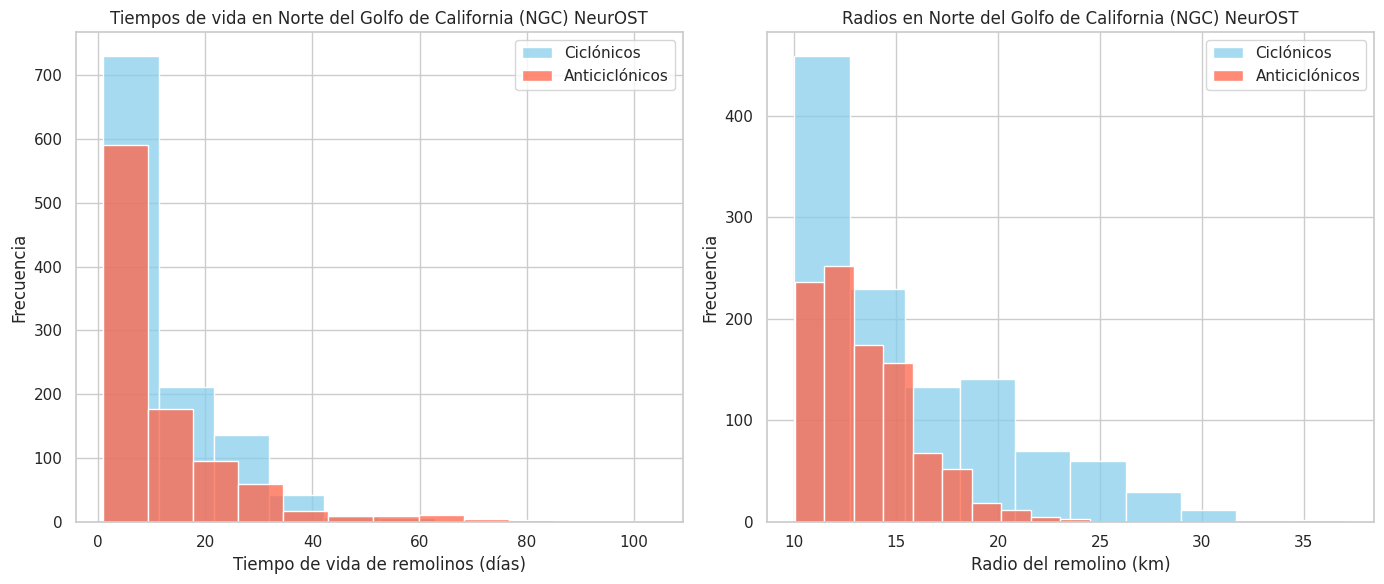

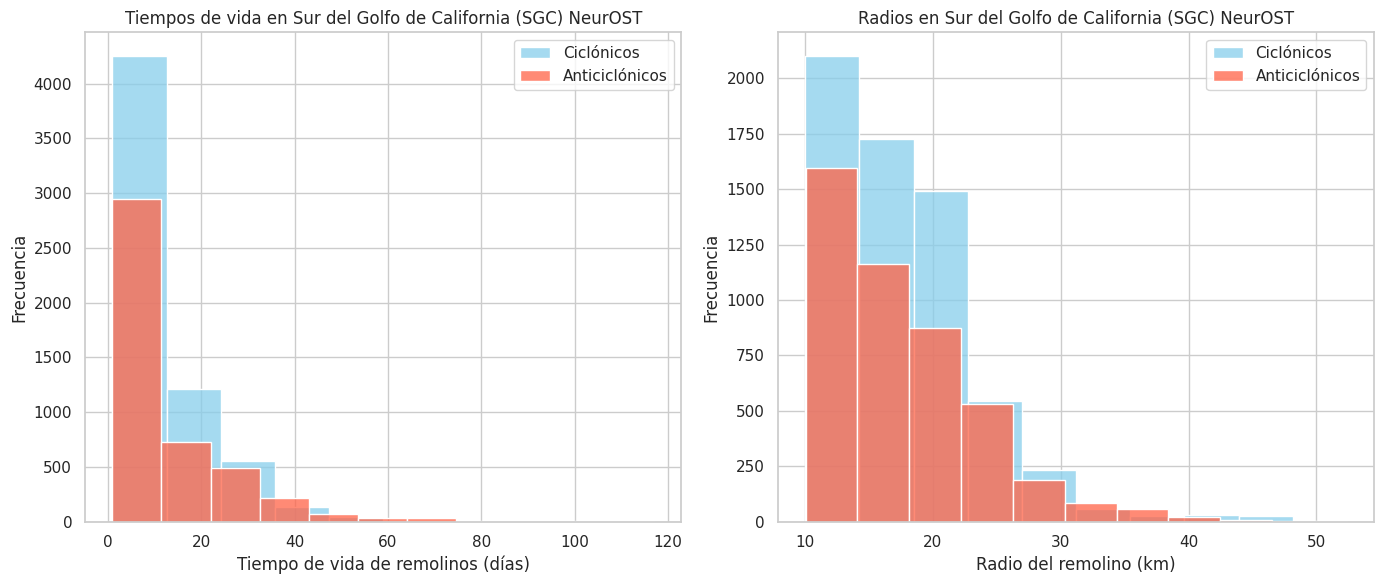

In [2]:
# Graficar histogramas de tiempos de vida y radios en un mismo gráfico
for bounds, region_name in zip([NGC_bounds, CGC_SGC_bounds],
                               ['Norte del Golfo de California (NGC)', 'Sur del Golfo de California (SGC)']):
    # Filtrar radios y tiempos de vida por región
    def filtrar_por_region(centros, valores, bounds):
        return [valor for valor, (lat, lon) in zip(valores, centros) if bounds[0] <= lat < bounds[1]]

    radios_region_ciclonicos = filtrar_por_region(centros_ciclonicos_total, radios_ciclonicos_total, bounds)
    tiempos_vida_region_ciclonicos = filtrar_por_region(centros_ciclonicos_total, tiempo_vida_ciclonicos_total, bounds)

    radios_region_anticiclonicos = filtrar_por_region(centros_anticiclonicos_total, radios_anticiclonicos_total, bounds)
    tiempos_vida_region_anticiclonicos = filtrar_por_region(centros_anticiclonicos_total, tiempo_vida_anticiclonicos_total, bounds)

    # Crear figuras para los histogramas de tiempos de vida y radios en una misma gráfica
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Histograma de tiempos de vida
    sns.histplot(tiempos_vida_region_ciclonicos, bins=10, color='skyblue', kde=False, ax=axes[0], label='Ciclónicos')
    sns.histplot(tiempos_vida_region_anticiclonicos, bins=10, color='tomato', kde=False, ax=axes[0], label='Anticiclónicos')
    axes[0].set_xlabel('Tiempo de vida de remolinos (días)')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title(f'Tiempos de vida en {region_name} NeurOST')
    axes[0].legend()

    # Histograma de radios
    sns.histplot(radios_region_ciclonicos, bins=10, color='skyblue', kde=False, ax=axes[1], label='Ciclónicos')
    sns.histplot(radios_region_anticiclonicos, bins=10, color='tomato', kde=False, ax=axes[1], label='Anticiclónicos')
    axes[1].set_xlabel('Radio del remolino (km)')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title(f'Radios en {region_name} NeurOST')
    axes[1].legend()

    plt.tight_layout()
    plt.show()



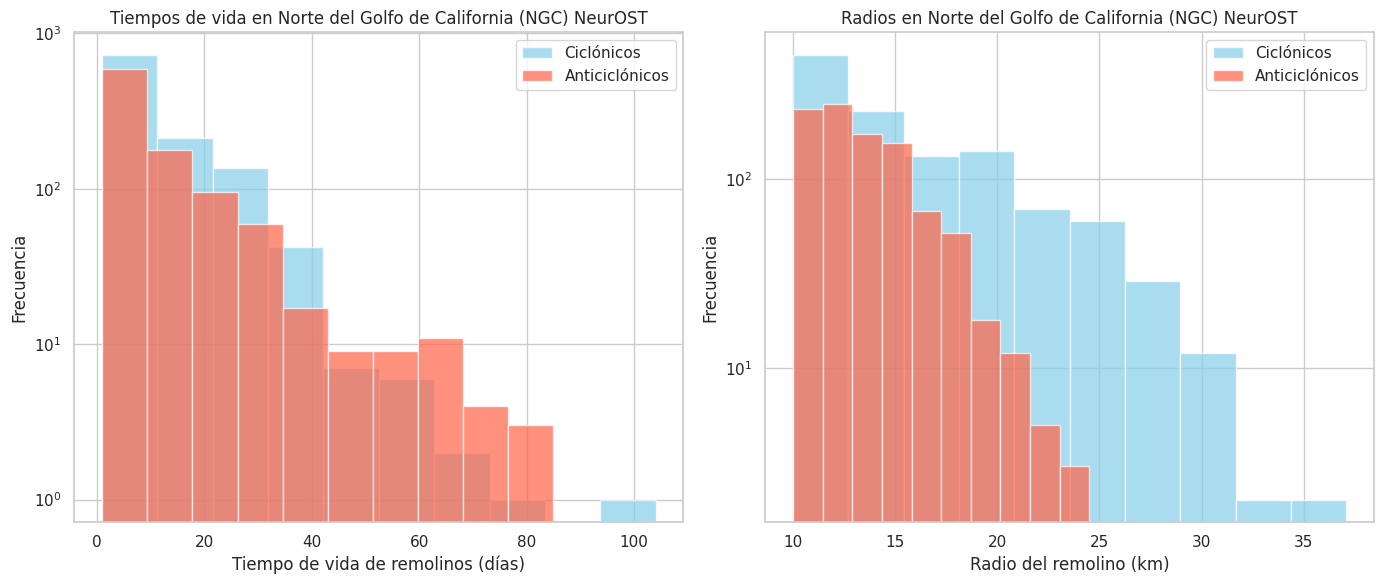

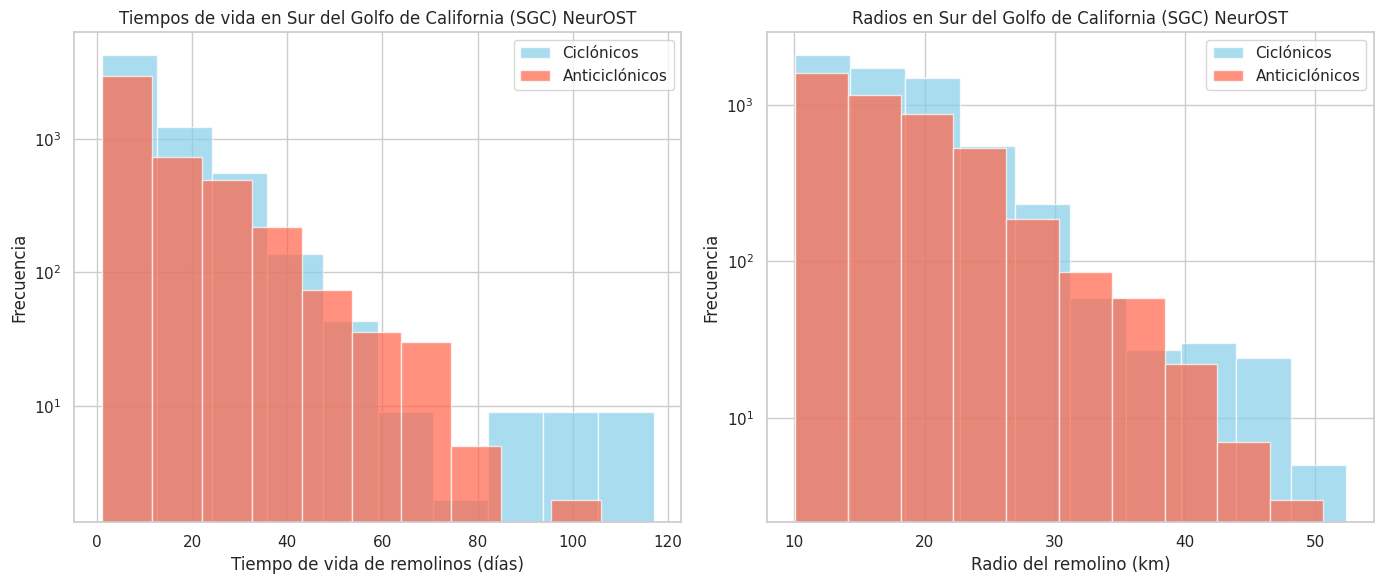

In [23]:
# Graficar histogramas de tiempos de vida y radios en un mismo gráfico (en escala logarítmica)
for bounds, region_name in zip([NGC_bounds, CGC_SGC_bounds],
                               ['Norte del Golfo de California (NGC)', 'Sur del Golfo de California (SGC)']):
    # Filtrar radios y tiempos de vida por región
    def filtrar_por_region(centros, valores, bounds):
        return [valor for valor, (lat, lon) in zip(valores, centros) if bounds[0] <= lat < bounds[1]]

    radios_region_ciclonicos = filtrar_por_region(centros_ciclonicos_total, radios_ciclonicos_total, bounds)
    tiempos_vida_region_ciclonicos = filtrar_por_region(centros_ciclonicos_total, tiempo_vida_ciclonicos_total, bounds)

    radios_region_anticiclonicos = filtrar_por_region(centros_anticiclonicos_total, radios_anticiclonicos_total, bounds)
    tiempos_vida_region_anticiclonicos = filtrar_por_region(centros_anticiclonicos_total, tiempo_vida_anticiclonicos_total, bounds)

    # Crear figuras para los histogramas de tiempos de vida y radios en una misma gráfica (en escala logarítmica)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Histograma de tiempos de vida (escala logarítmica)
    axes[0].hist(tiempos_vida_region_ciclonicos, bins=10, color='skyblue', label='Ciclónicos', alpha=0.7)
    axes[0].hist(tiempos_vida_region_anticiclonicos, bins=10, color='tomato', label='Anticiclónicos', alpha=0.7)
    axes[0].set_xlabel('Tiempo de vida de remolinos (días)')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title(f'Tiempos de vida en {region_name} NeurOST')
    axes[0].set_yscale('log')
    axes[0].legend()

    # Histograma de radios (escala logarítmica)
    axes[1].hist(radios_region_ciclonicos, bins=10, color='skyblue', label='Ciclónicos', alpha=0.7)
    axes[1].hist(radios_region_anticiclonicos, bins=10, color='tomato', label='Anticiclónicos', alpha=0.7)
    axes[1].set_xlabel('Radio del remolino (km)')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title(f'Radios en {region_name} NeurOST')
    axes[1].set_yscale('log')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


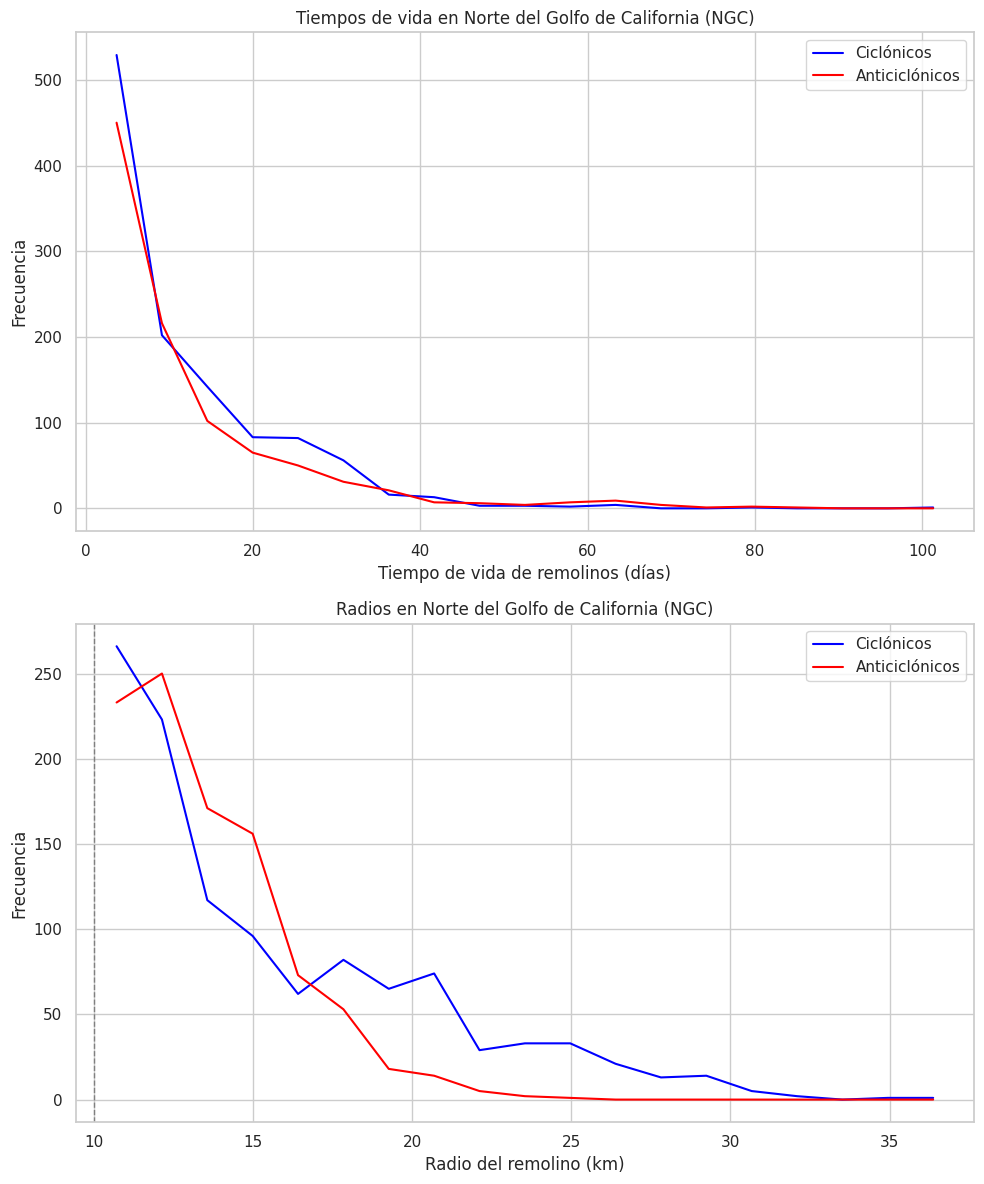

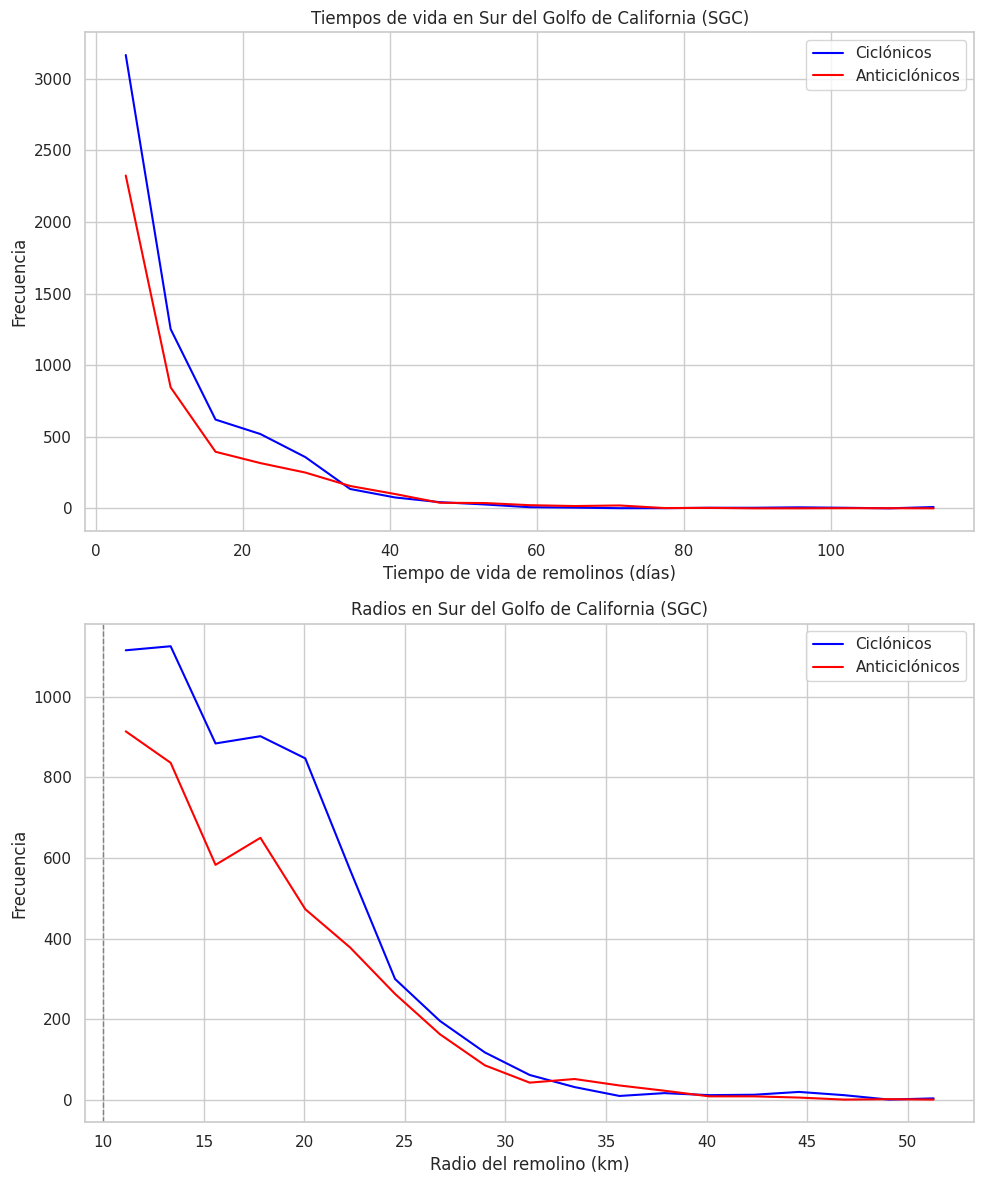

In [28]:
##GRafico en frecuencia azul y rojo

import numpy as np
import matplotlib.pyplot as plt

# Filtrar y graficar líneas de tiempos de vida y radios en un mismo gráfico
for bounds, region_name in zip([NGC_bounds, CGC_SGC_bounds],
                               ['Norte del Golfo de California (NGC)', 'Sur del Golfo de California (SGC)']):
    # Filtrar radios y tiempos de vida por región
    def filtrar_por_region(centros, valores, bounds):
        return [valor for valor, (lat, lon) in zip(valores, centros) if bounds[0] <= lat < bounds[1]]

    radios_region_ciclonicos = filtrar_por_region(centros_ciclonicos_total, radios_ciclonicos_total, bounds)
    tiempos_vida_region_ciclonicos = filtrar_por_region(centros_ciclonicos_total, tiempo_vida_ciclonicos_total, bounds)

    radios_region_anticiclonicos = filtrar_por_region(centros_anticiclonicos_total, radios_anticiclonicos_total, bounds)
    tiempos_vida_region_anticiclonicos = filtrar_por_region(centros_anticiclonicos_total, tiempo_vida_anticiclonicos_total, bounds)

    # Crear figuras para los gráficos (2-1 layout)
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Gráfico de tiempos de vida
    bins = np.linspace(min(tiempos_vida_region_ciclonicos + tiempos_vida_region_anticiclonicos),
                       max(tiempos_vida_region_ciclonicos + tiempos_vida_region_anticiclonicos), 20)
    hist_ciclonicos, bin_edges = np.histogram(tiempos_vida_region_ciclonicos, bins=bins)
    hist_anticiclonicos, _ = np.histogram(tiempos_vida_region_anticiclonicos, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    axes[0].plot(bin_centers, hist_ciclonicos, color='blue', label='Ciclónicos', linestyle='-')
    axes[0].plot(bin_centers, hist_anticiclonicos, color='red', label='Anticiclónicos', linestyle='-')
    axes[0].set_xlabel('Tiempo de vida de remolinos (días)')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title(f'Tiempos de vida en {region_name}')
    axes[0].legend()
    axes[0].grid(True)

    # Gráfico de radios
    bins = np.linspace(min(radios_region_ciclonicos + radios_region_anticiclonicos),
                       max(radios_region_ciclonicos + radios_region_anticiclonicos), 20)
    hist_ciclonicos, bin_edges = np.histogram(radios_region_ciclonicos, bins=bins)
    hist_anticiclonicos, _ = np.histogram(radios_region_anticiclonicos, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    axes[1].plot(bin_centers, hist_ciclonicos, color='blue', label='Ciclónicos', linestyle='-')
    axes[1].plot(bin_centers, hist_anticiclonicos, color='red', label='Anticiclónicos', linestyle='-')
    axes[1].axvline(x=10, color='grey', linestyle='--', linewidth=1)
    axes[1].set_xlabel('Radio del remolino (km)')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title(f'Radios en {region_name}')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

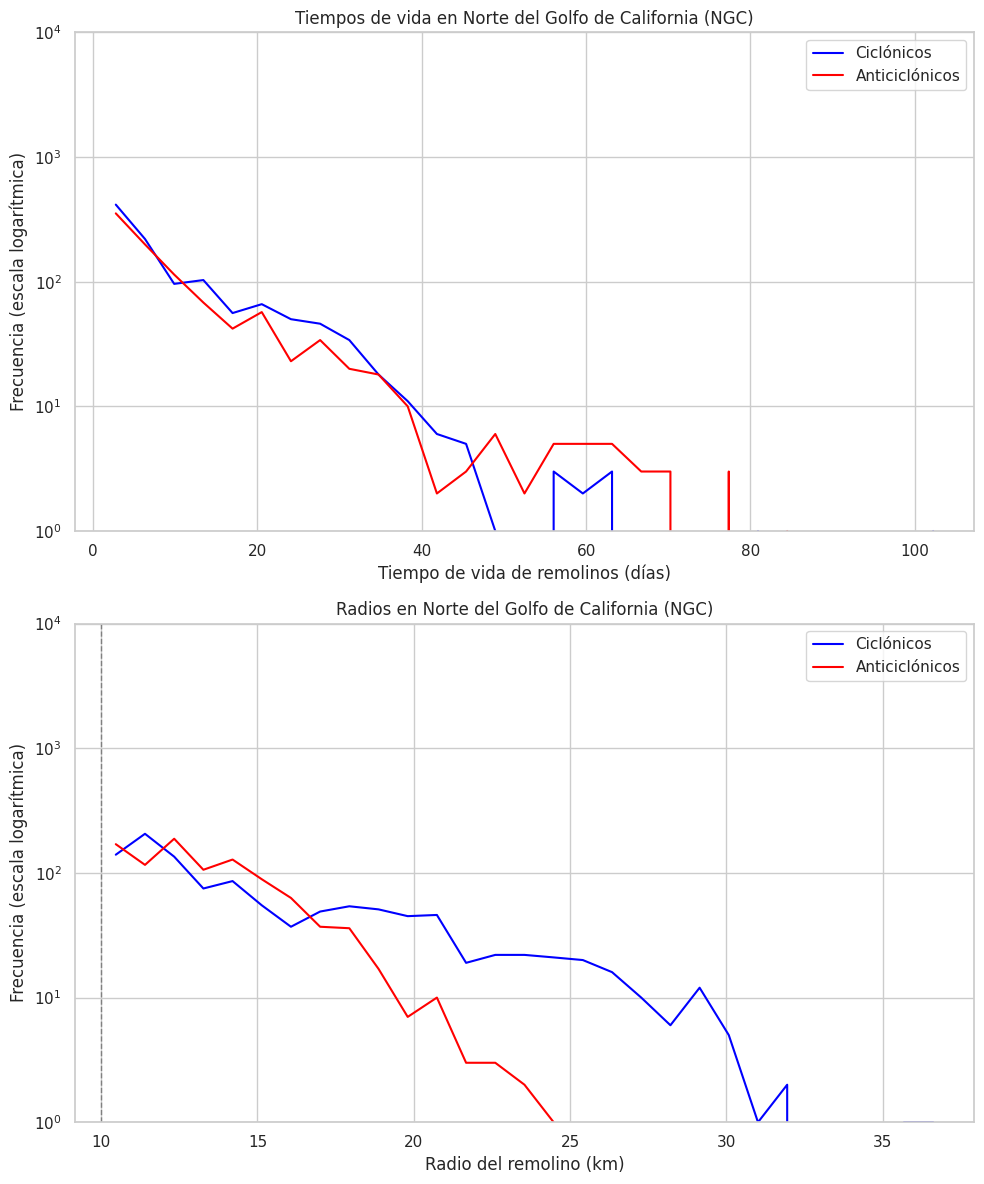

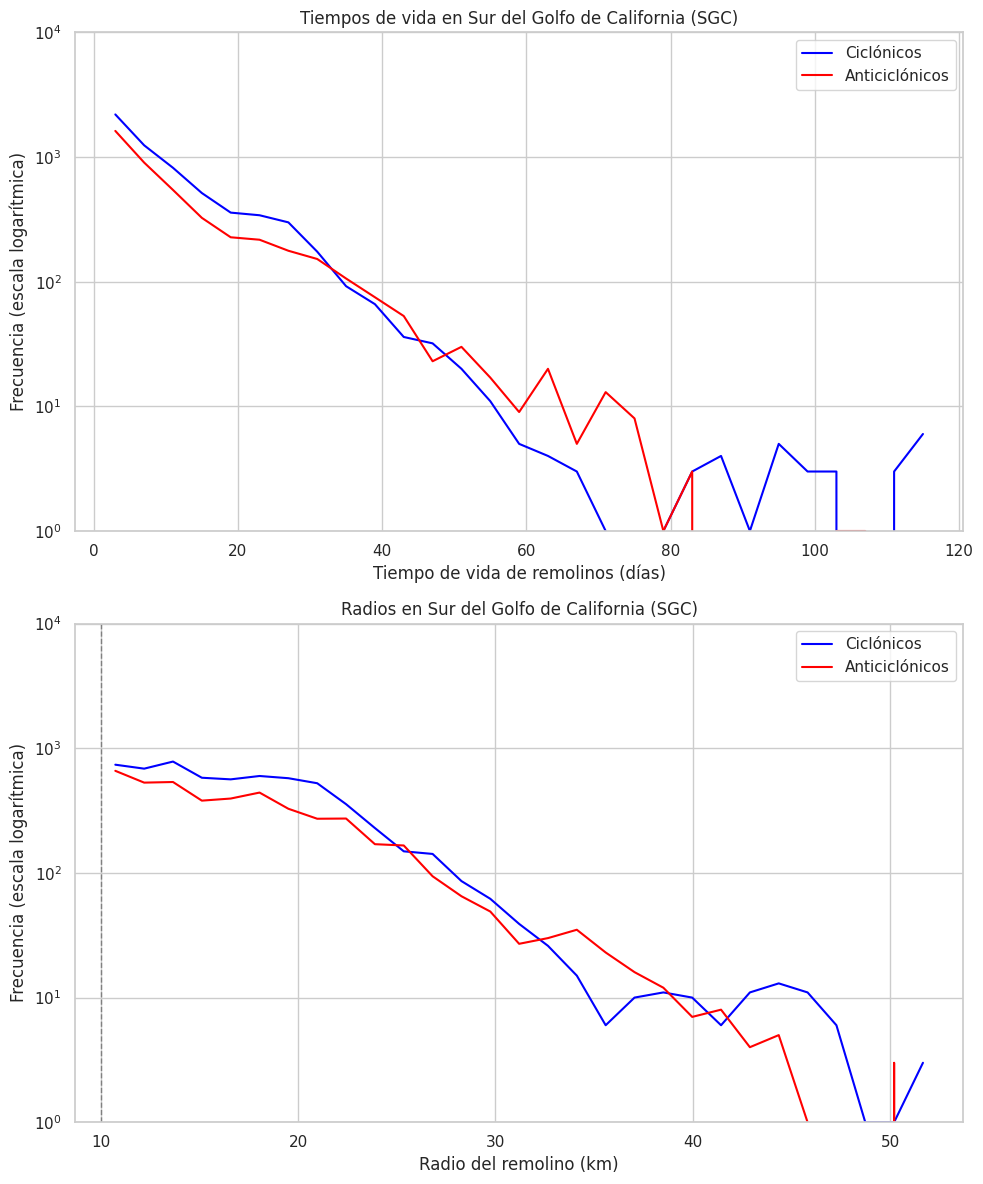

In [27]:
## Grafico logarotmico azul y rojo

import numpy as np
import matplotlib.pyplot as plt

# Filtrar y graficar líneas de tiempos de vida y radios en un mismo gráfico
for bounds, region_name in zip([NGC_bounds, CGC_SGC_bounds],
                               ['Norte del Golfo de California (NGC)', 'Sur del Golfo de California (SGC)']):
    # Filtrar radios y tiempos de vida por región
    def filtrar_por_region(centros, valores, bounds):
        return [valor for valor, (lat, lon) in zip(valores, centros) if bounds[0] <= lat < bounds[1]]

    radios_region_ciclonicos = filtrar_por_region(centros_ciclonicos_total, radios_ciclonicos_total, bounds)
    tiempos_vida_region_ciclonicos = filtrar_por_region(centros_ciclonicos_total, tiempo_vida_ciclonicos_total, bounds)

    radios_region_anticiclonicos = filtrar_por_region(centros_anticiclonicos_total, radios_anticiclonicos_total, bounds)
    tiempos_vida_region_anticiclonicos = filtrar_por_region(centros_anticiclonicos_total, tiempo_vida_anticiclonicos_total, bounds)

    # Crear figuras para los gráficos (2-1 layout)
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Gráfico de tiempos de vida
    bins = np.linspace(min(tiempos_vida_region_ciclonicos + tiempos_vida_region_anticiclonicos),
                       max(tiempos_vida_region_ciclonicos + tiempos_vida_region_anticiclonicos), 30)
    hist_ciclonicos, bin_edges = np.histogram(tiempos_vida_region_ciclonicos, bins=bins)
    hist_anticiclonicos, _ = np.histogram(tiempos_vida_region_anticiclonicos, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    axes[0].plot(bin_centers, hist_ciclonicos, color='blue', label='Ciclónicos', linestyle='-')
    axes[0].plot(bin_centers, hist_anticiclonicos, color='red', label='Anticiclónicos', linestyle='-')
    axes[0].set_ylim(1, 10e3)
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Tiempo de vida de remolinos (días)')
    axes[0].set_ylabel('Frecuencia (escala logarítmica)')
    
    axes[0].set_title(f'Tiempos de vida en {region_name}')
    axes[0].legend()
    axes[0].grid(True)

    # Gráfico de radios
    bins = np.linspace(min(radios_region_ciclonicos + radios_region_anticiclonicos),
                       max(radios_region_ciclonicos + radios_region_anticiclonicos), 30)
    hist_ciclonicos, bin_edges = np.histogram(radios_region_ciclonicos, bins=bins)
    hist_anticiclonicos, _ = np.histogram(radios_region_anticiclonicos, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    axes[1].plot(bin_centers, hist_ciclonicos, color='blue', label='Ciclónicos', linestyle='-')
    axes[1].plot(bin_centers, hist_anticiclonicos, color='red', label='Anticiclónicos', linestyle='-')
    axes[1].set_ylim(1, 10e3)
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Radio del remolino (km)')
    axes[1].set_ylabel('Frecuencia (escala logarítmica)')
    axes[1].axvline(x=10, color='grey', linestyle='--', linewidth=1)
    axes[1].set_title(f'Radios en {region_name}')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


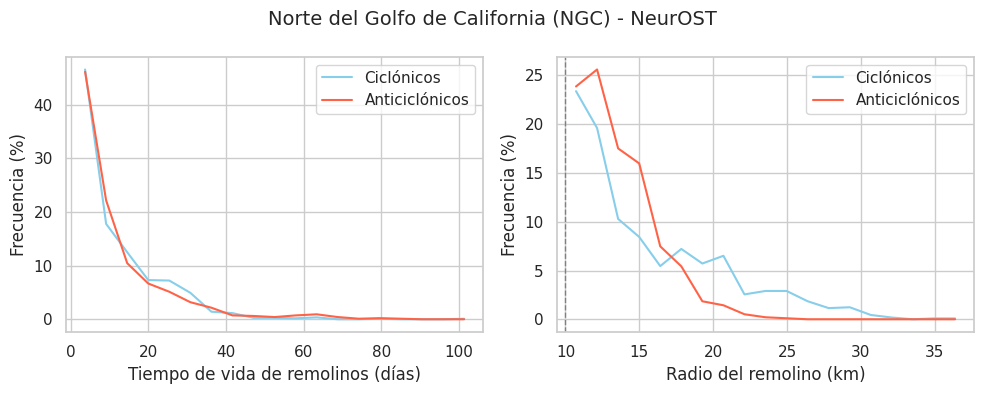

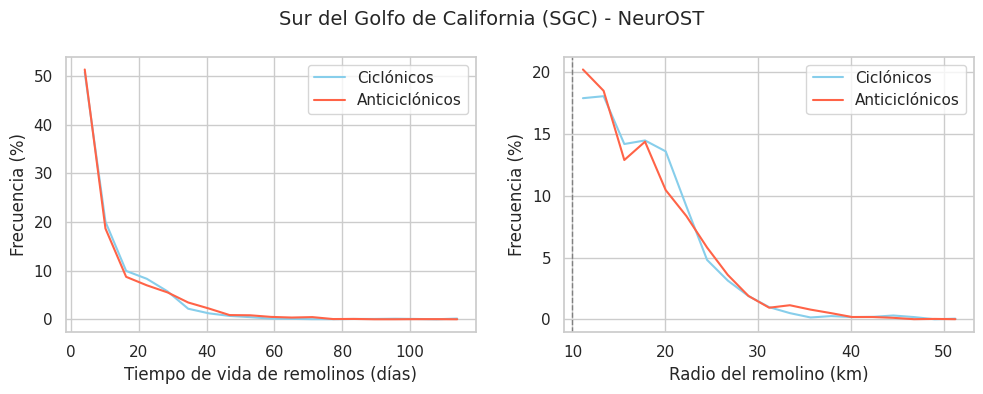

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Filtrar y graficar líneas de tiempos de vida y radios en un mismo gráfico
for bounds, region_name in zip([NGC_bounds, CGC_SGC_bounds],
                               ['Norte del Golfo de California (NGC)', 'Sur del Golfo de California (SGC)']):
    # Filtrar radios y tiempos de vida por región
    def filtrar_por_region(centros, valores, bounds):
        return [valor for valor, (lat, lon) in zip(valores, centros) if bounds[0] <= lat < bounds[1]]

    radios_region_ciclonicos = filtrar_por_region(centros_ciclonicos_total, radios_ciclonicos_total, bounds)
    tiempos_vida_region_ciclonicos = filtrar_por_region(centros_ciclonicos_total, tiempo_vida_ciclonicos_total, bounds)

    radios_region_anticiclonicos = filtrar_por_region(centros_anticiclonicos_total, radios_anticiclonicos_total, bounds)
    tiempos_vida_region_anticiclonicos = filtrar_por_region(centros_anticiclonicos_total, tiempo_vida_anticiclonicos_total, bounds)

    # Crear figuras para los gráficos (2-1 layout)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Gráfico de tiempos de vida
    bins = np.linspace(min(tiempos_vida_region_ciclonicos + tiempos_vida_region_anticiclonicos),
                       max(tiempos_vida_region_ciclonicos + tiempos_vida_region_anticiclonicos), 20)
    hist_ciclonicos, bin_edges = np.histogram(tiempos_vida_region_ciclonicos, bins=bins)
    hist_ciclonicos = (hist_ciclonicos / sum(hist_ciclonicos)) * 100
    hist_anticiclonicos, _ = np.histogram(tiempos_vida_region_anticiclonicos, bins=bins)
    hist_anticiclonicos = (hist_anticiclonicos / sum(hist_anticiclonicos)) * 100
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    axes[0].plot(bin_centers, hist_ciclonicos, color='skyblue', label='Ciclónicos', linestyle='-')
    axes[0].plot(bin_centers, hist_anticiclonicos, color='tomato', label='Anticiclónicos', linestyle='-')
    axes[0].set_xlabel('Tiempo de vida de remolinos (días)')
    axes[0].set_ylabel('Frecuencia (%)')
    axes[0].legend()
    axes[0].grid(True)

    # Gráfico de radios
    bins = np.linspace(min(radios_region_ciclonicos + radios_region_anticiclonicos),
                       max(radios_region_ciclonicos + radios_region_anticiclonicos), 20)
    hist_ciclonicos, bin_edges = np.histogram(radios_region_ciclonicos, bins=bins)
    hist_ciclonicos = (hist_ciclonicos / sum(hist_ciclonicos)) * 100
    hist_anticiclonicos, _ = np.histogram(radios_region_anticiclonicos, bins=bins)
    hist_anticiclonicos = (hist_anticiclonicos / sum(hist_anticiclonicos)) * 100
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    axes[1].plot(bin_centers, hist_ciclonicos, color='skyblue', label='Ciclónicos', linestyle='-')
    axes[1].plot(bin_centers, hist_anticiclonicos, color='tomato', label='Anticiclónicos', linestyle='-')
    
    axes[1].set_xlabel('Radio del remolino (km)')
    axes[1].set_ylabel('Frecuencia (%)')
    axes[1].axvline(x=10, color='grey', linestyle='--', linewidth=1)
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(f'{region_name} - NeurOST', fontsize=14)

    plt.tight_layout()
    plt.show()


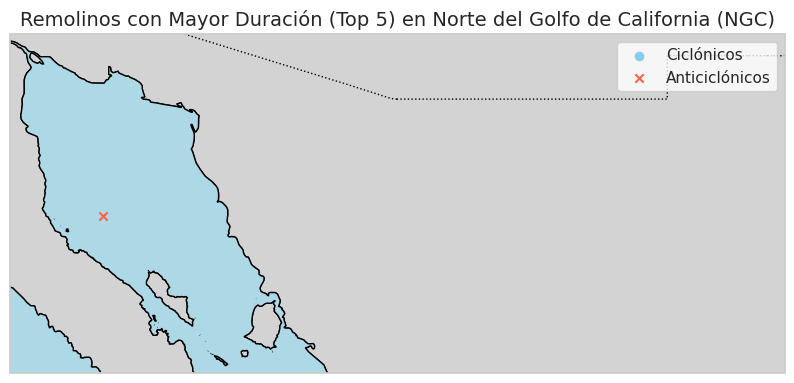

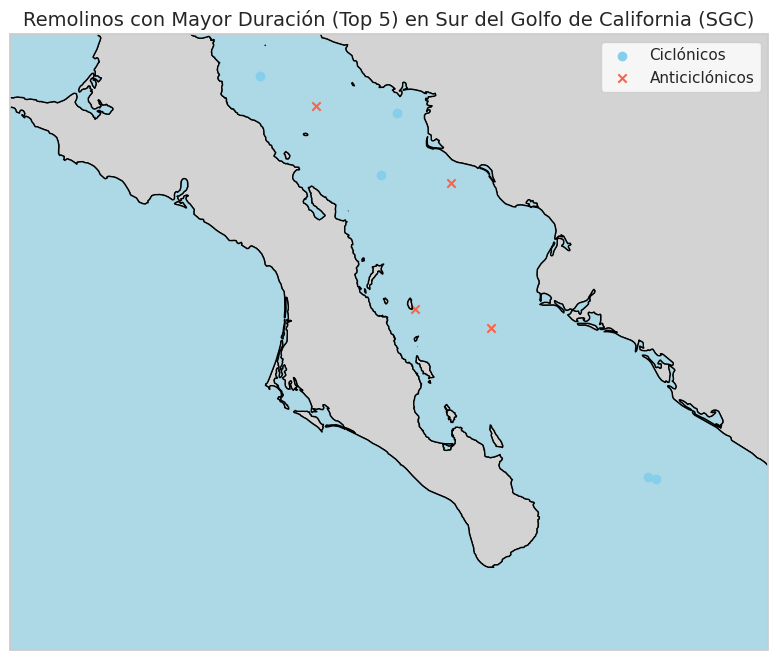

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Definir los límites de las regiones del Golfo de California (latitudes y longitudes)
NGC_bounds = (28.5, 32, -115, -107)  # Norte del Golfo de California (lat_min, lat_max, lon_min, lon_max)
CGC_SGC_bounds = (22, 28.5, -115, -107)  # Centro y Sur del Golfo de California (lat_min, lat_max, lon_min, lon_max)

# Filtrar remolinos con el top N de mayor duración
def obtener_top_n_mayor_duracion(centros, duraciones, n=5):
    # Verificar que ambas listas tengan la misma longitud
    if len(centros) != len(duraciones):
        min_len = min(len(centros), len(duraciones))
        centros = centros[:min_len]
        duraciones = duraciones[:min_len]

    # Ordenar por duración de mayor a menor y seleccionar los top N
    sorted_indices = np.argsort(duraciones)[::-1]  # Ordenar de mayor a menor
    top_indices = sorted_indices[:n]  # Seleccionar los primeros n índices
    
    # Asegurarse de no exceder el rango de la lista de centros
    return [centros[i] for i in top_indices if i < len(centros)]

for bounds, region_name in zip([NGC_bounds, CGC_SGC_bounds],
                               ['Norte del Golfo de California (NGC)', 'Sur del Golfo de California (SGC)']):
    # Filtrar remolinos con mayor duración en cada región (top 5)
    centros_ciclonicos_mayor_duracion = obtener_top_n_mayor_duracion(centros_ciclonicos_total, tiempo_vida_ciclonicos_total, n=5)
    centros_anticiclonicos_mayor_duracion = obtener_top_n_mayor_duracion(centros_anticiclonicos_total, tiempo_vida_anticiclonicos_total, n=5)

    # Graficar en un mapa los remolinos con mayor duración (top 5)
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([bounds[2], bounds[3], bounds[0], bounds[1]], crs=ccrs.PlateCarree())

    # Añadir características de la costa
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Añadir características del terreno y océano
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Graficar remolinos ciclónicos y anticiclónicos con mayor duración
    if centros_ciclonicos_mayor_duracion:
        latitudes_ciclonicos, longitudes_ciclonicos = zip(*centros_ciclonicos_mayor_duracion)
        ax.scatter(longitudes_ciclonicos, latitudes_ciclonicos, color='skyblue', label='Ciclónicos', marker='o')

    if centros_anticiclonicos_mayor_duracion:
        latitudes_anticiclonicos, longitudes_anticiclonicos = zip(*centros_anticiclonicos_mayor_duracion)
        ax.scatter(longitudes_anticiclonicos, latitudes_anticiclonicos, color='tomato', label='Anticiclónicos', marker='x')

    # Añadir leyenda y título
    ax.legend()
    ax.set_title(f'Remolinos con Mayor Duración (Top 5) en {region_name}', fontsize=14)
    plt.show()


Valores únicos en ciclonic_labeled: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Valores únicos en anticiclonic_labeled: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Intentando graficar remolino con etiqueta 13
Graficando remolino con etiqueta 13, duración: 30 días
Intentando graficar remolino con etiqueta 6
Graficando remolino con etiqueta 6, duración: 12 días
Intentando graficar remolino con etiqueta 14
Graficando remolino con etiqueta 14, duración: 9 días
Intentando graficar remolino con etiqueta 7
Graficando remolino con etiqueta 7, duración: 3 días
Intentando graficar remolino con etiqueta 1
Graficando remolino con etiqueta 1, duración: 27 días
Intentando graficar remolino con etiqueta 2
Graficando remolino con etiqueta 2, duración: 27 días
Intentando graficar remolino con etiqueta 4
Graficando remolino con etiqueta 4, duración: 26 días
Intentando graficar remolino con etiqueta 11
Graficando remolino con etiqueta 11, duración: 26 días
Intentando graficar remolino con 

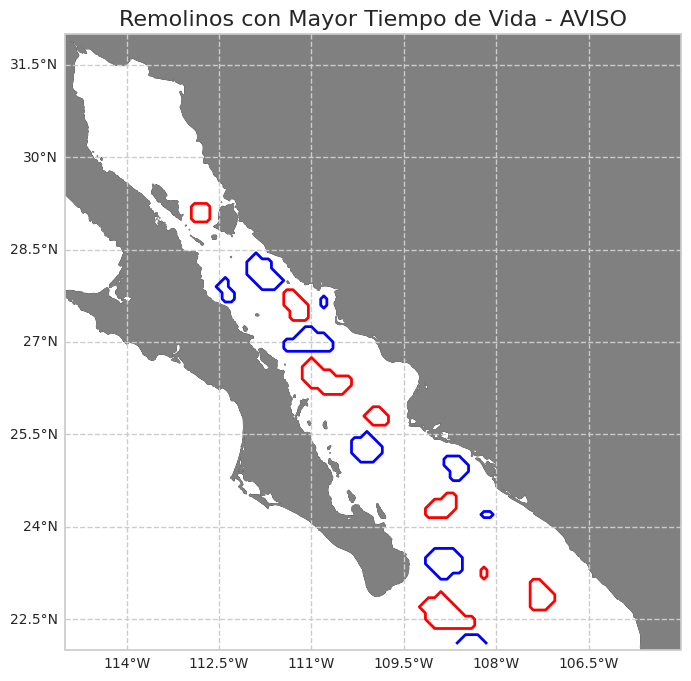

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Definir los límites de las regiones del Golfo de California (latitudes y longitudes)
NGC_bounds = (28.5, 32)  # Norte del Golfo de California
CGC_SGC_bounds = (22, 28.5)  # Centro y Sur del Golfo de California

# Función para calcular la forma del remolino a partir de la etiqueta
def calcular_forma_remolino(labeled, label_value):
    # Crear una matriz binaria donde se marque el remolino especificado
    forma_remolino = (labeled == label_value).astype(float)
    return forma_remolino

# Función para crear un diccionario de remolinos por etiqueta
def crear_diccionario_remolinos(centros, tiempos_vida, radios, labels):
    remolinos_dict = {}
    for centro, tiempo, radio, label in zip(centros, tiempos_vida, radios, labels):
        if label != 0:  # Ignorar el fondo (etiqueta 0)
            remolinos_dict[label] = {
                'centro': centro,
                'tiempo': tiempo,
                'radio': radio
            }
    return remolinos_dict

# Crear diccionarios para los remolinos ciclónicos y anticiclónicos
ciclonic_dict = crear_diccionario_remolinos(centros_ciclonicos_total, tiempo_vida_ciclonicos_total, radios_ciclonicos_total, np.unique(ciclonic_labeled)[1:])
anticiclonico_dict = crear_diccionario_remolinos(centros_anticiclonicos_total, tiempo_vida_anticiclonicos_total, radios_anticiclonicos_total, np.unique(anticiclonic_labeled)[1:])

# Función para filtrar los remolinos por región y obtener los 5 con mayor tiempo de vida
def filtrar_remolinos_por_region(remolinos_dict, bounds):
    remolinos_region = [
        (label, data) for label, data in remolinos_dict.items() if bounds[0] <= data['centro'][0] < bounds[1]
    ]
    # Ordenar los remolinos por tiempo de vida y seleccionar los 5 más largos
    remolinos_region_ordenados = sorted(remolinos_region, key=lambda x: x[1]['tiempo'], reverse=True)[:5]
    return remolinos_region_ordenados

# Filtrar los remolinos por región para ciclónicos y anticiclónicos
remolinos_norte_ciclonicos = filtrar_remolinos_por_region(ciclonic_dict, NGC_bounds)
remolinos_sur_ciclonicos = filtrar_remolinos_por_region(ciclonic_dict, CGC_SGC_bounds)
remolinos_norte_anticiclonicos = filtrar_remolinos_por_region(anticiclonico_dict, NGC_bounds)
remolinos_sur_anticiclonicos = filtrar_remolinos_por_region(anticiclonico_dict, CGC_SGC_bounds)

# Verificar valores únicos en labeled
print("Valores únicos en ciclonic_labeled:", np.unique(ciclonic_labeled))
print("Valores únicos en anticiclonic_labeled:", np.unique(anticiclonic_labeled))

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    ax.set_extent([-115, -105, 22, 32], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

# Graficar los 5 remolinos más duraderos ciclónicos y anticiclónicos por región
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
add_map_features(ax)

# Función para graficar los contornos del remolino usando `contour`
def graficar_remolino_por_region(labeled_array, remolinos, color, ax):
    for label_value, data in remolinos:
        # Imprimir el valor de la etiqueta que se está buscando
        print(f"Intentando graficar remolino con etiqueta {label_value}")

        # Calcular la forma del remolino
        forma_remolino = calcular_forma_remolino(labeled_array, label_value)
        
        # Verificar si hay valores significativos en la matriz
        if np.any(forma_remolino):
            print(f"Graficando remolino con etiqueta {label_value}, duración: {data['tiempo']} días")
            
            # Graficar el contorno del remolino usando `contour()`
            ax.contour(X, Y, forma_remolino, levels=[0.5], colors=color, linewidths=2, transform=ccrs.PlateCarree())
        else:
            print(f"No se encontraron puntos para la etiqueta {label_value}")

# Graficar remolinos del norte y sur (ciclónicos y anticiclónicos) usando `contour()` para mostrar contornos
graficar_remolino_por_region(ciclonic_labeled, remolinos_norte_ciclonicos, 'blue', ax)
graficar_remolino_por_region(ciclonic_labeled, remolinos_sur_ciclonicos, 'blue', ax)
graficar_remolino_por_region(anticiclonic_labeled, remolinos_norte_anticiclonicos, 'red', ax)
graficar_remolino_por_region(anticiclonic_labeled, remolinos_sur_anticiclonicos, 'red', ax)

# Añadir leyenda y título
plt.title(f'Remolinos con Mayor Tiempo de Vida - AVISO', fontsize=16)
plt.show()



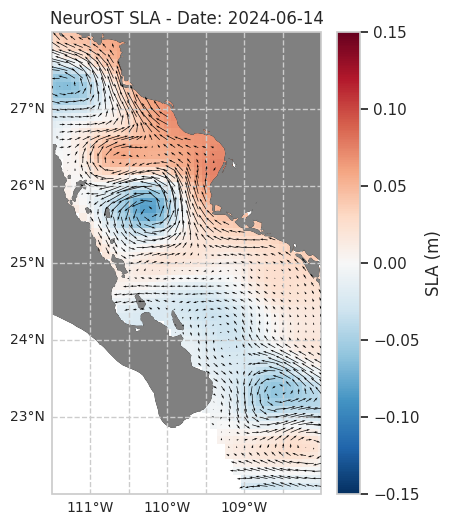

In [66]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
from datetime import datetime
from scipy.io import loadmat
import re
from matplotlib.path import Path
from scipy.signal import detrend
import pandas as pd
import os

# Función para extraer las fechas del nombre del archivo
def extract_dates_from_filename(filename):
    date_pattern = r'(\d{8})'
    dates = re.findall(date_pattern, filename)
    if len(dates) >= 2:
        start_date = datetime.strptime(dates[0], '%Y%m%d')
        end_date = datetime.strptime(dates[1], '%Y%m%d')
        return start_date, end_date
    else:
        raise ValueError("El nombre del archivo no contiene dos fechas en el formato esperado.")

# Obtener todos los archivos en la carpeta especificada
folder_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/GC'
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.nc')]

# Ordenar los archivos alfabéticamente
file_list.sort()

# Definir las fechas deseadas manualmente
start_date = datetime(2024, 6, 14)
end_date = datetime(2024, 7, 22)

# Inicializar listas para almacenar datos combinados
combined_sla_data = []
combined_ugos_data = []
combined_vgos_data = []
combined_time = []

# Cargar cada archivo y extraer los datos de SLA, UGOS, VGOS dentro del rango de fechas
for file_path in file_list:
    data = xr.open_dataset(file_path)
    time_data = pd.to_datetime(data['time'].values)
    if time_data[0] >= start_date and time_data[0] <= end_date:
        combined_sla_data.append(data['sla'])
        combined_ugos_data.append(data['ugos'])
        combined_vgos_data.append(data['vgos'])
        combined_time.append(data['time'])

# Concatenar todos los datos
sla_data = xr.concat(combined_sla_data, dim='time')
ugos_data = xr.concat(combined_ugos_data, dim='time')
vgos_data = xr.concat(combined_vgos_data, dim='time')
combined_time = xr.concat(combined_time, dim='time')

# Cargar máscara del Golfo de California
mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
xp = mask_data['xp'].flatten() + 360
yp = mask_data['yp'].flatten()
polygon_path = Path(np.column_stack((xp, yp)))

# Crear la figura y el mapa con Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(resolution='10m', zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    ax.set_extent([-111.5, -108, 22, 28], crs=ccrs.PlateCarree())  # sur del golfo
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

# Añadir las características al mapa
add_map_features(ax)

# Crear el gráfico inicial para el primer frame
initial_data = sla_data.isel(time=0)
initial_ugos = ugos_data.isel(time=0)
initial_vgos = vgos_data.isel(time=0)
x = data['longitude'].values
y = data['latitude'].values
X, Y = np.meshgrid(x, y)
points = np.vstack((X.flatten(), Y.flatten())).T
mask = polygon_path.contains_points(points).reshape(X.shape)

# Aplicar la máscara a los datos iniciales
masked_sla = np.where(mask, initial_data.values, np.nan)
finite_masked_sla = masked_sla[np.isfinite(masked_sla)]
masked_ugos = np.where(mask, initial_ugos.values, np.nan)
masked_vgos = np.where(mask, initial_vgos.values, np.nan)

# Aplicar detrend a los valores finitos dentro de la máscara
detrended_finite_sla = detrend(finite_masked_sla, type='linear')

# Reconstruir la matriz SLA detrendida con NaNs fuera de la máscara
detrended_sla = np.full_like(initial_data.values, np.nan)
detrended_sla[np.isfinite(masked_sla)] = detrended_finite_sla

# Crear el gráfico inicial
img = ax.pcolormesh(X, Y, detrended_sla, cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree(), vmin=-0.15, vmax=0.15)
cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('SLA (m)')

# Añadir las corrientes como vectores
quiver = ax.quiver(X, Y, masked_ugos, masked_vgos, scale=5, transform=ccrs.PlateCarree(), color='black', zorder=3)

# Función de actualización para la animación
def update(frame):
    current_data = sla_data.isel(time=frame)
    current_ugos = ugos_data.isel(time=frame)
    current_vgos = vgos_data.isel(time=frame)
    masked_sla = np.where(mask, current_data.values, np.nan)
    finite_masked_sla = masked_sla[np.isfinite(masked_sla)]
    detrended_finite_sla = detrend(finite_masked_sla, type='linear')
    detrended_sla = np.full_like(current_data.values, np.nan)
    detrended_sla[np.isfinite(masked_sla)] = detrended_finite_sla
    masked_ugos = np.where(mask, current_ugos.values, np.nan)
    masked_vgos = np.where(mask, current_vgos.values, np.nan)
    img.set_array(detrended_sla.ravel())
    img.set_clim(vmin=-0.15, vmax=0.15)  # Asegurar los límites de color en cada frame
    ax.set_title(f"NeurOST SLA - Date: {pd.to_datetime(current_data.time.values).strftime('%Y-%m-%d')}")
    quiver.set_UVC(masked_ugos, masked_vgos)
    return img, quiver

# Crear la animación
ani = FuncAnimation(fig, update, frames=len(sla_data['time']), interval=200, blit=False)

# Mostrar la animación en el Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
from datetime import datetime
from scipy.io import loadmat
import re
from matplotlib.path import Path
from scipy.signal import detrend
import pandas as pd
import os

def extract_dates_from_filename(filename):
    date_pattern = r'(?:[^_]*_){2}(\d{8})'
    dates = re.findall(date_pattern, filename)
    if len(dates) == 1:
        start_date = datetime.strptime(dates[0], '%Y%m%d')
        return start_date
    else:
        raise ValueError("El nombre del archivo no contiene una fecha en la tercera posición con el formato esperado.")


# Obtener todos los archivos en la carpeta especificada
folder_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024'
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.nc')]

# Ordenar los archivos alfabéticamente
file_list.sort()

# Definir las fechas deseadas manualmente
start_date = datetime(2024, 6, 1)
end_date = datetime(2024, 6, 14)

# Filtrar los archivos que estén dentro del rango de fechas antes de cargarlos
filtered_file_list = []
for file_path in file_list:
    try:
        file_start_date = extract_dates_from_filename(file_path)
        if start_date <= file_start_date <= end_date:
            print(f"Archivo dentro del rango de fechas: {file_path}")
            filtered_file_list.append(file_path)
    except ValueError as e:
        print(f"Error procesando el archivo {file_path}: {e}")


print("Lista de archivos a procesar (filtrados por fecha):")
for file_path in filtered_file_list:
    print(file_path)

# Inicializar listas para almacenar datos combinados
combined_sla_data = []
combined_ugos_data = []
combined_vgos_data = []
combined_time = []

# Cargar cada archivo filtrado y extraer los datos de SLA, UGOS, VGOS
for file_path in filtered_file_list:
    data = xr.open_dataset(file_path)
    time_data = pd.to_datetime(data['time'].values)
    time_mask = (time_data >= start_date) & (time_data <= end_date)
    if time_mask.any():
        combined_sla_data.append(data['sla'].sel(time=time_mask))
        combined_ugos_data.append(data['ugos'].sel(time=time_mask))
        combined_vgos_data.append(data['vgos'].sel(time=time_mask))
        combined_time.append(data['time'].sel(time=time_mask))

# Concatenar todos los datos
if combined_sla_data:
    sla_data = xr.concat(combined_sla_data, dim='time')
    ugos_data = xr.concat(combined_ugos_data, dim='time')
    vgos_data = xr.concat(combined_vgos_data, dim='time')
    combined_time = xr.concat(combined_time, dim='time')
else:
    raise ValueError("No se encontraron datos dentro del rango de fechas especificado.")

# Cargar máscara del Golfo de California
mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
xp = mask_data['xp'].flatten() + 360
yp = mask_data['yp'].flatten()
polygon_path = Path(np.column_stack((xp, yp)))

# Crear la figura y el mapa con Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(resolution='10m', zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    #ax.set_extent([-111.5, -108, 22, 28], crs=ccrs.PlateCarree())  # sur del golfo
    ax.set_extent([-115, -108, 22, 32], crs=ccrs.PlateCarree())  # Golfo de California
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

# Añadir las características al mapa
add_map_features(ax)

# Crear el gráfico inicial para el primer frame
initial_data = sla_data.isel(time=0)
initial_ugos = ugos_data.isel(time=0)
initial_vgos = vgos_data.isel(time=0)
x = sla_data['longitude'].values
y = sla_data['latitude'].values
X, Y = np.meshgrid(x, y)
points = np.vstack((X.flatten(), Y.flatten())).T
mask = polygon_path.contains_points(points).reshape(X.shape)

# Aplicar la máscara a los datos iniciales
masked_sla = np.where(mask, initial_data.values, np.nan)
finite_masked_sla = masked_sla[np.isfinite(masked_sla)]
masked_ugos = np.where(mask, initial_ugos.values, np.nan)
masked_vgos = np.where(mask, initial_vgos.values, np.nan)

# Aplicar detrend a los valores finitos dentro de la máscara
detrended_finite_sla = detrend(finite_masked_sla, type='linear')

# Reconstruir la matriz SLA detrendida con NaNs fuera de la máscara
detrended_sla = np.full_like(initial_data.values, np.nan)
detrended_sla[np.isfinite(masked_sla)] = detrended_finite_sla

# Crear el gráfico inicial
img = ax.pcolormesh(X, Y, detrended_sla, cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree(), vmin=-0.15, vmax=0.15)
cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('SLA (m)')

# Añadir las corrientes como vectores
quiver = ax.quiver(X, Y, masked_ugos, masked_vgos, scale=5, transform=ccrs.PlateCarree(), color='black', zorder=3)

# Función de actualización para la animación
def update(frame):
    current_data = sla_data.isel(time=frame)
    current_ugos = ugos_data.isel(time=frame)
    current_vgos = vgos_data.isel(time=frame)
    masked_sla = np.where(mask, current_data.values, np.nan)
    finite_masked_sla = masked_sla[np.isfinite(masked_sla)]
    detrended_finite_sla = detrend(finite_masked_sla, type='linear')
    detrended_sla = np.full_like(current_data.values, np.nan)
    detrended_sla[np.isfinite(masked_sla)] = detrended_finite_sla
    masked_ugos = np.where(mask, current_ugos.values, np.nan)
    masked_vgos = np.where(mask, current_vgos.values, np.nan)
    img.set_array(detrended_sla.ravel())
    img.set_clim(vmin=-0.15, vmax=0.15)  # Asegurar los límites de color en cada frame
    img.set_array(detrended_sla.ravel())  # Corregir actualización del array
    ax.set_title(f"NeurOST SLA - Date: {pd.to_datetime(current_data.time.values).strftime('%Y-%m-%d')}")
    quiver.set_UVC(masked_ugos, masked_vgos)
    return img, quiver

# Crear la animación
ani = FuncAnimation(fig, update, frames=len(sla_data['time']), interval=200, blit=False)

# Mostrar la animación en el Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())


Archivo dentro del rango de fechas: /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240601_20240722.nc
Archivo dentro del rango de fechas: /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240602_20240722.nc
Archivo dentro del rango de fechas: /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240603_20240722.nc
Archivo dentro del rango de fechas: /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240604_20240722.nc
Archivo dentro del rango de fechas: /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240605_20240722.nc
Archivo dentro del rango de fechas: /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240606_20240722.nc
Archivo dentro del rango de fechas: /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240607_20240722.nc
Archivo dentro del rango de fechas: /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20240608_20240722.nc
Archivo 

Fecha extraída del archivo /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20211231_20240507.nc: 2021-12-31 00:00:00
Fecha extraída del archivo /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20211231_20240507.nc: 2021-12-31 00:00:00
Archivo fuera del rango de fechas: /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20211231_20240507.nc con fecha 2021-12-31 00:00:00
Fecha extraída del archivo /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20220101_20240507.nc: 2022-01-01 00:00:00
Fecha extraída del archivo /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20220101_20240507.nc: 2022-01-01 00:00:00
Archivo fuera del rango de fechas: /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20220101_20240507.nc con fecha 2022-01-01 00:00:00
Fecha extraída del archivo /mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024/NeurOST_SSH-SST_20220102_20240507.nc: 2022-01-02 00:00:00
Fecha extraída

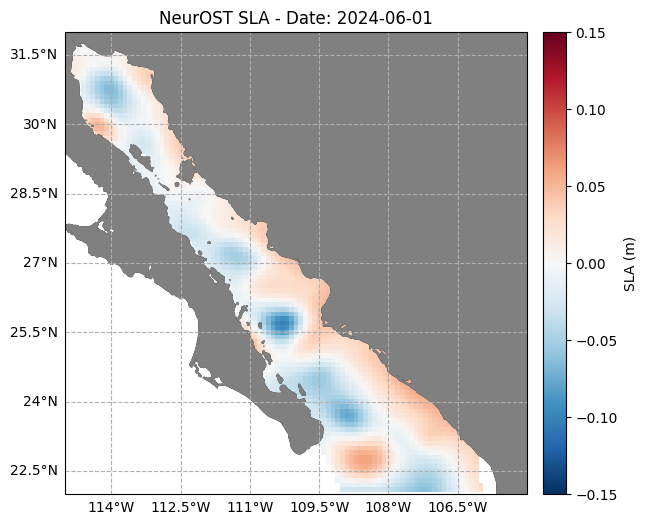

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
from datetime import datetime
from scipy.io import loadmat
import re
from matplotlib.path import Path
from scipy.signal import detrend
import pandas as pd
import os

# Función para extraer las fechas del nombre del archivo
def extract_dates_from_filename(filename):
    date_pattern = r'(?:[^_]*_){2}(\d{8})'
    dates = re.findall(date_pattern, filename)
    if len(dates) == 1:
        start_date = datetime.strptime(dates[0], '%Y%m%d')
        print(f"Fecha extraída del archivo {filename}: {start_date}")
        return start_date
    else:
        raise ValueError("El nombre del archivo no contiene una fecha en la tercera posición con el formato esperado.")

# Obtener todos los archivos en la carpeta especificada
folder_path = '/mnt/data/satelitales/SSH/NEUROST_SSH-SST_L4_V2024'
file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.nc')]

# Ordenar los archivos alfabéticamente
file_list.sort()

# Definir las fechas deseadas manualmente
start_date = datetime(2024, 6, 1)
end_date = datetime(2024, 6, 14)

# Filtrar los archivos que estén dentro del rango de fechas antes de cargarlos
filtered_file_list = []
for file_path in file_list:
    try:
        file_start_date = extract_dates_from_filename(file_path)
        print(f"Fecha extraída del archivo {file_path}: {file_start_date}")
        if start_date <= file_start_date <= end_date:
            filtered_file_list.append(file_path)
            print(f"Archivo dentro del rango de fechas: {file_path}")
        else:
            print(f"Archivo fuera del rango de fechas: {file_path} con fecha {file_start_date}")
    except ValueError as e:
        print(f"Error procesando el archivo {file_path}: {e}")

print("Lista de archivos a procesar (filtrados por fecha):")
for file_path in filtered_file_list:
    print(file_path)

# Inicializar listas para almacenar datos combinados
combined_sla_data = []
combined_ugos_data = []
combined_vgos_data = []
combined_time = []

# Cargar cada archivo filtrado y extraer los datos de SLA, UGOS, VGOS
for file_path in filtered_file_list:
    data = xr.open_dataset(file_path)
    combined_sla_data.append(data['sla'])
    combined_ugos_data.append(data['ugos'])
    combined_vgos_data.append(data['vgos'])
    combined_time.append(data['time'])

# Concatenar todos los datos
if combined_sla_data:
    sla_data = xr.concat(combined_sla_data, dim='time')
    ugos_data = xr.concat(combined_ugos_data, dim='time')
    vgos_data = xr.concat(combined_vgos_data, dim='time')
    combined_time = xr.concat(combined_time, dim='time')
else:
    raise ValueError("No se encontraron datos dentro del rango de fechas especificado.")

# Cargar máscara del Golfo de California
mask_data = loadmat('GC_mask.mat')  # Ajusta la ruta según la ubicación de tu archivo
xp = mask_data['xp'].flatten() + 360
yp = mask_data['yp'].flatten()
polygon_path = Path(np.column_stack((xp, yp)))

# Crear la figura y el mapa con Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

# Función para agregar características al mapa
def add_map_features(ax):
    ax.coastlines(resolution='10m', zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.LAND, color='gray', zorder=2, edgecolor='black')
    ax.set_extent([-115, -105, 22, 32], crs=ccrs.PlateCarree())
    #ax.set_extent([-111.5, -108, 22, 28], crs=ccrs.PlateCarree())  # sur del golfo
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

# Añadir las características al mapa
add_map_features(ax)

# Crear el gráfico inicial para el primer frame
initial_data = sla_data.isel(time=0)
initial_ugos = ugos_data.isel(time=0)
initial_vgos = vgos_data.isel(time=0)
x = sla_data['longitude'].values
y = sla_data['latitude'].values
X, Y = np.meshgrid(x, y)
points = np.vstack((X.flatten(), Y.flatten())).T
mask = polygon_path.contains_points(points).reshape(X.shape)

# Aplicar la máscara a los datos iniciales
masked_sla = np.where(mask, initial_data.values, np.nan)
finite_masked_sla = masked_sla[np.isfinite(masked_sla)]
masked_ugos = np.where(mask, initial_ugos.values, np.nan)
masked_vgos = np.where(mask, initial_vgos.values, np.nan)

# Aplicar detrend a los valores finitos dentro de la máscara
detrended_finite_sla = detrend(finite_masked_sla, type='linear')

# Reconstruir la matriz SLA detrendida con NaNs fuera de la máscara
detrended_sla = np.full_like(initial_data.values, np.nan)
detrended_sla[np.isfinite(masked_sla)] = detrended_finite_sla

# Crear el gráfico inicial
img = ax.pcolormesh(X, Y, detrended_sla, cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree(), vmin=-0.15, vmax=0.15)
cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label('SLA (m)')

# Añadir las corrientes como vectores
#quiver = ax.quiver(X, Y, masked_ugos, masked_vgos, scale=5, transform=ccrs.PlateCarree(), color='black', zorder=3)

# Función de actualización para la animación
def update(frame):
    current_data = sla_data.isel(time=frame)
    #current_ugos = ugos_data.isel(time=frame)
    #current_vgos = vgos_data.isel(time=frame)
    masked_sla = np.where(mask, current_data.values, np.nan)
    finite_masked_sla = masked_sla[np.isfinite(masked_sla)]
    detrended_finite_sla = detrend(finite_masked_sla, type='linear')
    detrended_sla = np.full_like(current_data.values, np.nan)
    detrended_sla[np.isfinite(masked_sla)] = detrended_finite_sla
    #masked_ugos = np.where(mask, current_ugos.values, np.nan)
    #masked_vgos = np.where(mask, current_vgos.values, np.nan)
    img.set_array(detrended_sla.flatten())
    img.set_clim(vmin=-0.15, vmax=0.15)  # Asegurar los límites de color en cada frame  # Corregir actualización del array
    ax.set_title(f"NeurOST SLA - Date: {pd.to_datetime(current_data.time.values).strftime('%Y-%m-%d')}")
    #quiver.set_UVC(masked_ugos, masked_vgos)
    return img, quiver

# Crear la animación
ani = FuncAnimation(fig, update, frames=len(sla_data['time']), interval=200, blit=False)

# Mostrar la animación en el Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())
